In [2]:
%run ../../cpch_source.py

In [4]:
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
#print(cpu_count())

cpus = 40
alpha = 0.05

In [6]:
from numpy.linalg import norm as npnorm    
from scipy.optimize import lsq_linear
from scipy.linalg import toeplitz
from numpy.linalg import inv

def lsq(y):
    y = np.array(y)
    d = y.shape[0]
    ub = np.array([np.inf]*d)
    lb = np.zeros(d)
    A = toeplitz([1] + [0]*(d-1), [1,-1] +[0]*(d-2))
    Ainv = inv(A)
    beta = lsq_linear(Ainv, y, bounds=(lb, ub), lsmr_tol='auto', verbose=0)
    return Ainv.dot(beta.x)    

def proj(v):
    v = np.array(v)
    if len(v) == 1:
        return np.maximum(v, 0)
    elif len(v) == 2:
        x, y = v
        if y <= 0:
            return np.array([max(x, 0), 0])
        elif y <= -x:
            return np.zeros(2)
        elif y <= x:
            return v
        else:
            e0 = np.ones(2)/np.sqrt(2)
            return v.dot(e0)*e0
    elif len(v) > 2:
        return lsq(v)

In [7]:
def gen_init(m, r, scale=5):
    arr = np.zeros(m)
    for j in range(r-1):
        if j == 0:
            arr[j] = np.random.rand(1)*scale
        else:
            arr[j] = np.random.rand(1)*arr[j-1]
    return arr

# m=4, r=3, Fisher

init at mu=[0.04679307 0.02335245 0.         0.        ]
epoch: 0, learn rate: 30.0
epoch: 10, learn rate: 25.0
epoch: 20, learn rate: 21.42857142857143
epoch: 30, learn rate: 18.75
epoch: 40, learn rate: 16.666666666666668
epoch: 50, learn rate: 15.0
epoch: 60, learn rate: 13.636363636363635
epoch: 70, learn rate: 12.499999999999998
epoch: 80, learn rate: 11.538461538461538
epoch: 90, learn rate: 10.714285714285715
epoch: 100, learn rate: 10.0
epoch: 110, learn rate: 9.375
epoch: 120, learn rate: 8.823529411764707
epoch: 130, learn rate: 8.333333333333334
epoch: 140, learn rate: 7.894736842105263
epoch: 150, learn rate: 7.5
epoch: 160, learn rate: 7.142857142857142
epoch: 170, learn rate: 6.8181818181818175
epoch: 180, learn rate: 6.521739130434783
epoch: 190, learn rate: 6.249999999999999
final epoch error: 0.0582
se cal: 0.0012909944487358056
max type I error: 0.0582 at mu = [2.25657399 2.24018683]


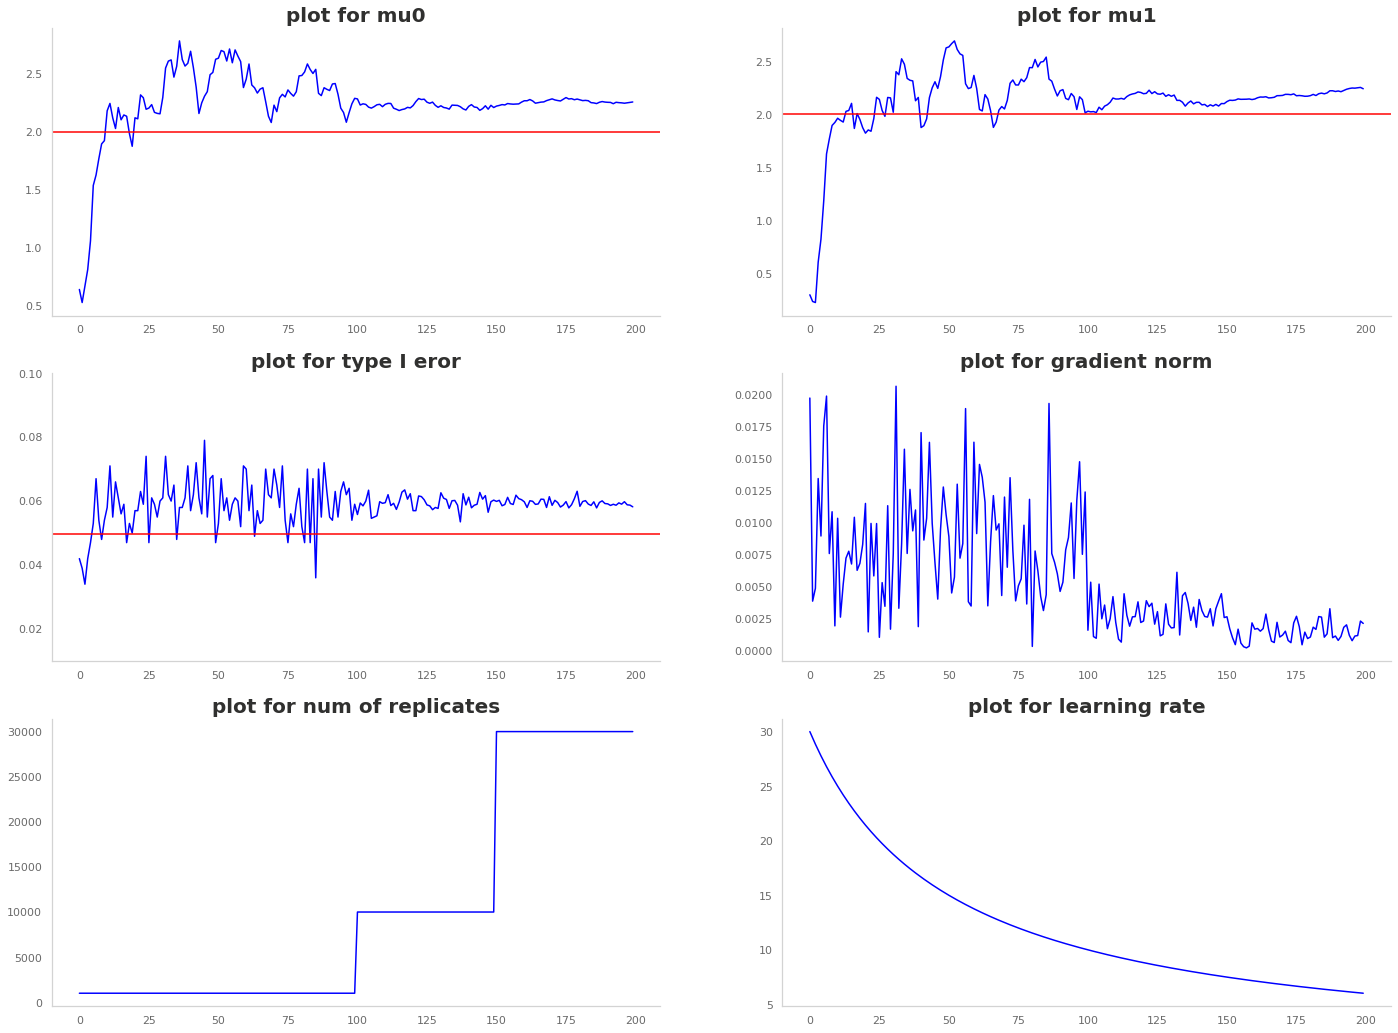

CPU times: user 11 s, sys: 27.6 s, total: 38.6 s
Wall time: 5min 7s


In [12]:
%%time
seed(2022)

m = 4
r = 3
k = r - 1

f = f_fisher
N = 500

    
def get_pvals_core(Z_hold, mu):
    XX = Z_hold + mu
    return cpch(XX, m, r, f, pdf=norm.pdf, cdf=norm.cdf, N=N)
def get_grad_core(Z_hold, pvals_hold):
    return  -(Z_hold)[:,:(r-1)]*(pvals_hold <= alpha)[:, np.newaxis]

mu_cur = gen_init(m=m, r=r)
print(f'init at mu={mu_cur}')
mu_seq = []
err_seq = []
gradnorm_seq = [] 
Tmax = 200
lrate0 = 30
lrate_seq = [max(lrate0/(1 + 0.02*tt), 2) for tt in range(Tmax)]
K_seq = []
# lrate_seq = [lrate0*0.95**tt for tt in range()]
for tt in range(Tmax):
    ## exponential decay
    lrate = lrate_seq[tt]
    if tt % 10 == 0:
        print(f'epoch: {tt}, learn rate: {lrate}')
    if tt < 100:
        K = 1e3
        # K = 96*1280
    elif tt < 150:
        K = 1e4
    else:
        K = 3e4#1e5
    K = int(K)
    K_seq.append(K)
    ## shuffle for mini batch
    # Z_mini = normal(scale=1, size=[K, n])
    # X_mini = Z_mini + mu_cur
    # pvals = get_pvals_core(Z_mini, mu_cur)
    # grads = get_grad(n, r, X_mini, mu_cur, pvals, alpha)
    
    Z_list = [normal(scale=1, size=[K//cpus, m]) for _ in range(cpus)]
    Z_all = np.vstack(Z_list)
    star_args = [[Z_list[o], mu_cur] for o in range(cpus)]
    with Pool(processes=cpus) as pool:
        pvals= np.hstack(pool.starmap(get_pvals_core, star_args))
    grads = get_grad_core(Z_all, pvals)
    
    diff = lrate*grads.mean(axis=0)
    mu_cur[:(r-1)] = proj(mu_cur[:(r-1)] - diff)
    mu_seq.append(mu_cur[:(r-1)].copy())
    err_seq.append((pvals <= alpha).mean())
    gradnorm_seq.append(npnorm(grads.mean(axis=0), np.inf))
mu_seq = np.vstack(mu_seq)
print('final epoch error:', err_seq[-1])

print('se cal:', np.sqrt(1/20/K))
print('max type I error:', err_seq[-1], 'at mu =', mu_seq[-1,:])

fig, axs = plt.subplots(3, max(mu_seq.shape[1], 2), figsize = (24, 18))
for i in range(mu_seq.shape[1]):
    _ = axs[0,i].plot(range(mu_seq.shape[0]), mu_seq[:,i], color = 'blue')
    axs[0,i].axhline(y=2, c="red")
    axs[0,i].set_title(f'plot for mu{i}', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,0].plot(range(len(err_seq)), err_seq, color = 'blue')
axs[1,0].axhline(y=0.0496, c="red")
axs[1,0].set_ylim([0.01, 0.1])
axs[1,0].set_title(f'plot for type I eror', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,1].plot(range(len(gradnorm_seq)), gradnorm_seq, color = 'blue')
axs[1,1].set_title(f'plot for gradient norm', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,0].plot(range(len(K_seq)), K_seq, color = 'blue')
axs[2,0].set_title(f'plot for num of replicates', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,1].plot(range(len(lrate_seq)), lrate_seq, color = 'blue')
axs[2,1].set_title(f'plot for learning rate', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
plt.show()

# m=r=2

init at mu=[0.04679307 0.        ]
epoch: 0, learn rate: 30.0
epoch: 10, learn rate: 25.0
epoch: 20, learn rate: 21.42857142857143
epoch: 30, learn rate: 18.75
epoch: 40, learn rate: 16.666666666666668
epoch: 50, learn rate: 15.0
epoch: 60, learn rate: 13.636363636363635
epoch: 70, learn rate: 12.499999999999998
epoch: 80, learn rate: 11.538461538461538
epoch: 90, learn rate: 10.714285714285715
epoch: 100, learn rate: 10.0
epoch: 110, learn rate: 9.375
epoch: 120, learn rate: 8.823529411764707
epoch: 130, learn rate: 8.333333333333334
epoch: 140, learn rate: 7.894736842105263
epoch: 150, learn rate: 7.5
epoch: 160, learn rate: 7.142857142857142
epoch: 170, learn rate: 6.8181818181818175
epoch: 180, learn rate: 6.521739130434783
epoch: 190, learn rate: 6.249999999999999
final epoch error: 0.05973333333333333
se cal: 0.0012909944487358056
max type I error: 0.05973333333333333 at mu = [2.02162579]


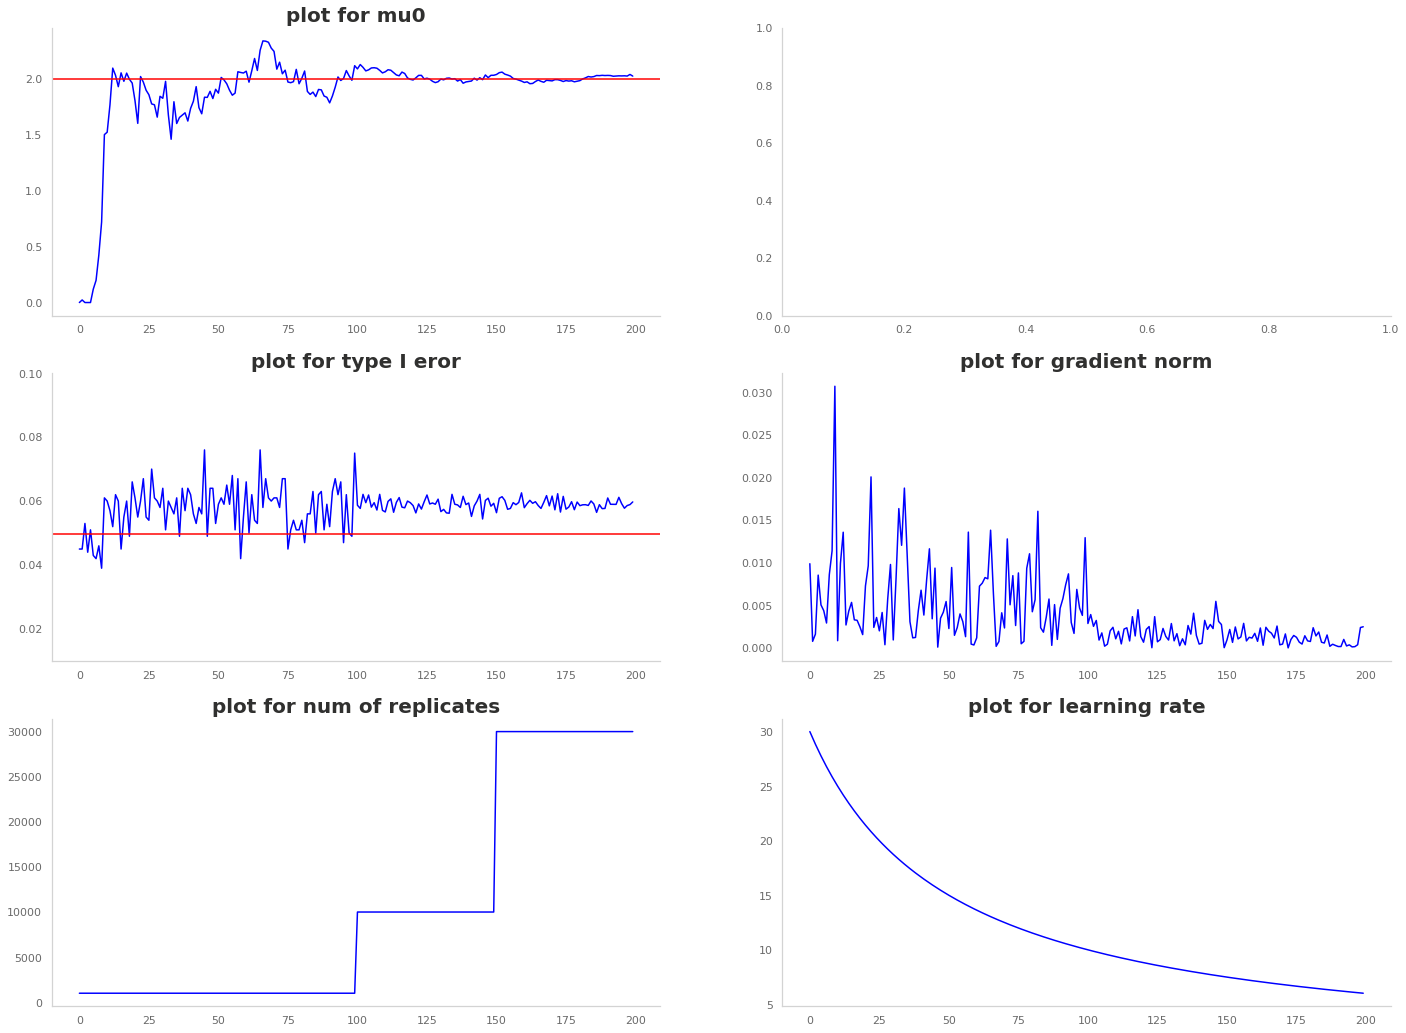

CPU times: user 10.2 s, sys: 30.2 s, total: 40.4 s
Wall time: 44.6 s


In [14]:
%%time
seed(2022)

# def get_pvals(Z_hold, n, r, mu, S, H, N, f = None):
#     if f == None:
#         f = f_fisher
#     XX = Z_hold + mu
#     cond_thres = Vget_cond_thres(XX, n, r)
#     muhat, XXs = Vget_muhat_Xs(XX, n, r)
#     return Vmm_mc_norm(XXs, S, H, f, muhat, cond_thres, N)

m = 2
r = 2
k = r - 1

f = f_fisher
N = 500

    
def get_pvals_core(Z_hold, mu):
    XX = Z_hold + mu
    return cpch(XX, m, r, f, pdf=norm.pdf, cdf=norm.cdf, N=N)
def get_grad_core(Z_hold, pvals_hold):
    return  -(Z_hold)[:,:(r-1)]*(pvals_hold <= alpha)[:, np.newaxis]

mu_cur = gen_init(m=m, r=r)
print(f'init at mu={mu_cur}')
mu_seq = []
err_seq = []
gradnorm_seq = [] 
Tmax = 200
lrate0 = 30
lrate_seq = [max(lrate0/(1 + 0.02*tt), 2) for tt in range(Tmax)]
K_seq = []
# lrate_seq = [lrate0*0.95**tt for tt in range()]
for tt in range(Tmax):
    ## exponential decay
    lrate = lrate_seq[tt]
    if tt % 10 == 0:
        print(f'epoch: {tt}, learn rate: {lrate}')
    if tt < 100:
        K = 1e3
        # K = 96*1280
    elif tt < 150:
        K = 1e4
    else:
        K = 3e4#1e5
    K = int(K)
    K_seq.append(K)
    ## shuffle for mini batch
    # Z_mini = normal(scale=1, size=[K, n])
    # X_mini = Z_mini + mu_cur
    # pvals = get_pvals_core(Z_mini, mu_cur)
    # grads = get_grad(n, r, X_mini, mu_cur, pvals, alpha)
    
    Z_list = [normal(scale=1, size=[K//cpus, m]) for _ in range(cpus)]
    Z_all = np.vstack(Z_list)
    star_args = [[Z_list[o], mu_cur] for o in range(cpus)]
    with Pool(processes=cpus) as pool:
        pvals= np.hstack(pool.starmap(get_pvals_core, star_args))
    grads = get_grad_core(Z_all, pvals)
    
    diff = lrate*grads.mean(axis=0)
    mu_cur[:(r-1)] = proj(mu_cur[:(r-1)] - diff)
    mu_seq.append(mu_cur[:(r-1)].copy())
    err_seq.append((pvals <= alpha).mean())
    gradnorm_seq.append(npnorm(grads.mean(axis=0), np.inf))
mu_seq = np.vstack(mu_seq)
print('final epoch error:', err_seq[-1])

print('se cal:', np.sqrt(1/20/K))
print('max type I error:', err_seq[-1], 'at mu =', mu_seq[-1,:])

fig, axs = plt.subplots(3, max(mu_seq.shape[1], 2), figsize = (24, 18))
for i in range(mu_seq.shape[1]):
    _ = axs[0,i].plot(range(mu_seq.shape[0]), mu_seq[:,i], color = 'blue')
    axs[0,i].axhline(y=2, c="red")
    axs[0,i].set_title(f'plot for mu{i}', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,0].plot(range(len(err_seq)), err_seq, color = 'blue')
axs[1,0].axhline(y=0.0496, c="red")
axs[1,0].set_ylim([0.01, 0.1])
axs[1,0].set_title(f'plot for type I eror', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,1].plot(range(len(gradnorm_seq)), gradnorm_seq, color = 'blue')
axs[1,1].set_title(f'plot for gradient norm', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,0].plot(range(len(K_seq)), K_seq, color = 'blue')
axs[2,0].set_title(f'plot for num of replicates', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,1].plot(range(len(lrate_seq)), lrate_seq, color = 'blue')
axs[2,1].set_title(f'plot for learning rate', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
plt.show()

# m=4, r=3

init at mu=[0.04679307 0.02335245 0.         0.        ]
epoch: 0, learn rate: 30.0
epoch: 10, learn rate: 25.0
epoch: 20, learn rate: 21.42857142857143
epoch: 30, learn rate: 18.75
epoch: 40, learn rate: 16.666666666666668
epoch: 50, learn rate: 15.0
epoch: 60, learn rate: 13.636363636363635
epoch: 70, learn rate: 12.499999999999998
epoch: 80, learn rate: 11.538461538461538
epoch: 90, learn rate: 10.714285714285715
epoch: 100, learn rate: 10.0
epoch: 110, learn rate: 9.375
epoch: 120, learn rate: 8.823529411764707
epoch: 130, learn rate: 8.333333333333334
epoch: 140, learn rate: 7.894736842105263
epoch: 150, learn rate: 7.5
epoch: 160, learn rate: 7.142857142857142
epoch: 170, learn rate: 6.8181818181818175
epoch: 180, learn rate: 6.521739130434783
epoch: 190, learn rate: 6.249999999999999
final epoch error: 0.06046666666666667
se cal: 0.0012909944487358056
max type I error: 0.06046666666666667 at mu = [2.4029664  2.38988265]


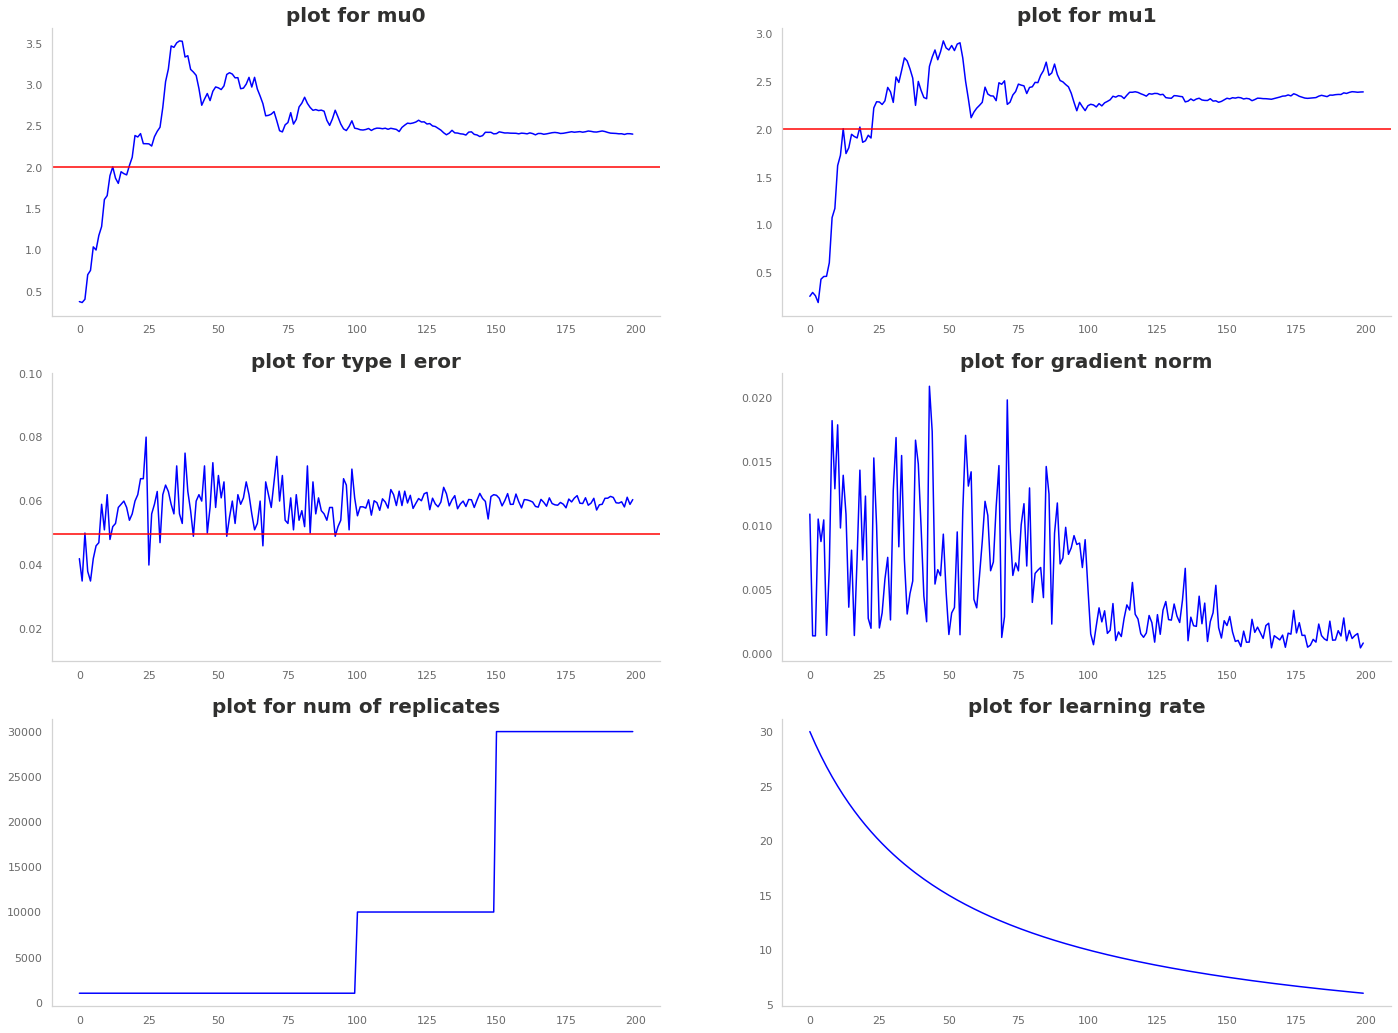

CPU times: user 11.2 s, sys: 26.6 s, total: 37.7 s
Wall time: 5min 38s


In [6]:
%%time
seed(2022)

# def get_pvals(Z_hold, n, r, mu, S, H, N, f = None):
#     if f == None:
#         f = f_fisher
#     XX = Z_hold + mu
#     cond_thres = Vget_cond_thres(XX, n, r)
#     muhat, XXs = Vget_muhat_Xs(XX, n, r)
#     return Vmm_mc_norm(XXs, S, H, f, muhat, cond_thres, N)

m = 4
r = 3
k = r - 1

f = f_simes
N = 500

    
def get_pvals_core(Z_hold, mu):
    XX = Z_hold + mu
    return cpch(XX, m, r, f, pdf=norm.pdf, cdf=norm.cdf, N=N)
def get_grad_core(Z_hold, pvals_hold):
    return  -(Z_hold)[:,:(r-1)]*(pvals_hold <= alpha)[:, np.newaxis]

mu_cur = gen_init(m=m, r=r)
print(f'init at mu={mu_cur}')
mu_seq = []
err_seq = []
gradnorm_seq = [] 
Tmax = 200
lrate0 = 30
lrate_seq = [max(lrate0/(1 + 0.02*tt), 2) for tt in range(Tmax)]
K_seq = []
# lrate_seq = [lrate0*0.95**tt for tt in range()]
for tt in range(Tmax):
    ## exponential decay
    lrate = lrate_seq[tt]
    if tt % 10 == 0:
        print(f'epoch: {tt}, learn rate: {lrate}')
    if tt < 100:
        K = 1e3
        # K = 96*1280
    elif tt < 150:
        K = 1e4
    else:
        K = 3e4#1e5
    K = int(K)
    K_seq.append(K)
    ## shuffle for mini batch
    # Z_mini = normal(scale=1, size=[K, n])
    # X_mini = Z_mini + mu_cur
    # pvals = get_pvals_core(Z_mini, mu_cur)
    # grads = get_grad(n, r, X_mini, mu_cur, pvals, alpha)
    
    Z_list = [normal(scale=1, size=[K//cpus, m]) for _ in range(cpus)]
    Z_all = np.vstack(Z_list)
    star_args = [[Z_list[o], mu_cur] for o in range(cpus)]
    with Pool(processes=cpus) as pool:
        pvals= np.hstack(pool.starmap(get_pvals_core, star_args))
    grads = get_grad_core(Z_all, pvals)
    
    diff = lrate*grads.mean(axis=0)
    mu_cur[:(r-1)] = proj(mu_cur[:(r-1)] - diff)
    mu_seq.append(mu_cur[:(r-1)].copy())
    err_seq.append((pvals <= alpha).mean())
    gradnorm_seq.append(npnorm(grads.mean(axis=0), np.inf))
mu_seq = np.vstack(mu_seq)
print('final epoch error:', err_seq[-1])

print('se cal:', np.sqrt(1/20/K))
print('max type I error:', err_seq[-1], 'at mu =', mu_seq[-1,:])

fig, axs = plt.subplots(3, max(mu_seq.shape[1], 2), figsize = (24, 18))
for i in range(mu_seq.shape[1]):
    _ = axs[0,i].plot(range(mu_seq.shape[0]), mu_seq[:,i], color = 'blue')
    axs[0,i].axhline(y=2, c="red")
    axs[0,i].set_title(f'plot for mu{i}', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,0].plot(range(len(err_seq)), err_seq, color = 'blue')
axs[1,0].axhline(y=0.0496, c="red")
axs[1,0].set_ylim([0.01, 0.1])
axs[1,0].set_title(f'plot for type I eror', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,1].plot(range(len(gradnorm_seq)), gradnorm_seq, color = 'blue')
axs[1,1].set_title(f'plot for gradient norm', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,0].plot(range(len(K_seq)), K_seq, color = 'blue')
axs[2,0].set_title(f'plot for num of replicates', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,1].plot(range(len(lrate_seq)), lrate_seq, color = 'blue')
axs[2,1].set_title(f'plot for learning rate', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
plt.show()

init at mu=[0.04679307 0.02335245 0.         0.        ]
epoch: 0, learn rate: 30.0
epoch: 10, learn rate: 25.0
epoch: 20, learn rate: 21.42857142857143
epoch: 30, learn rate: 18.75
epoch: 40, learn rate: 16.666666666666668
epoch: 50, learn rate: 15.0
epoch: 60, learn rate: 13.636363636363635
epoch: 70, learn rate: 12.499999999999998
epoch: 80, learn rate: 11.538461538461538
epoch: 90, learn rate: 10.714285714285715
epoch: 100, learn rate: 10.0
epoch: 110, learn rate: 9.375
epoch: 120, learn rate: 8.823529411764707
epoch: 130, learn rate: 8.333333333333334
epoch: 140, learn rate: 7.894736842105263
epoch: 150, learn rate: 7.5
epoch: 160, learn rate: 7.142857142857142
epoch: 170, learn rate: 6.8181818181818175
epoch: 180, learn rate: 6.521739130434783
epoch: 190, learn rate: 6.249999999999999
final epoch error: 0.0574
se cal: 0.0012909944487358056
max type I error: 0.0574 at mu = [2.4583562 2.4583562]


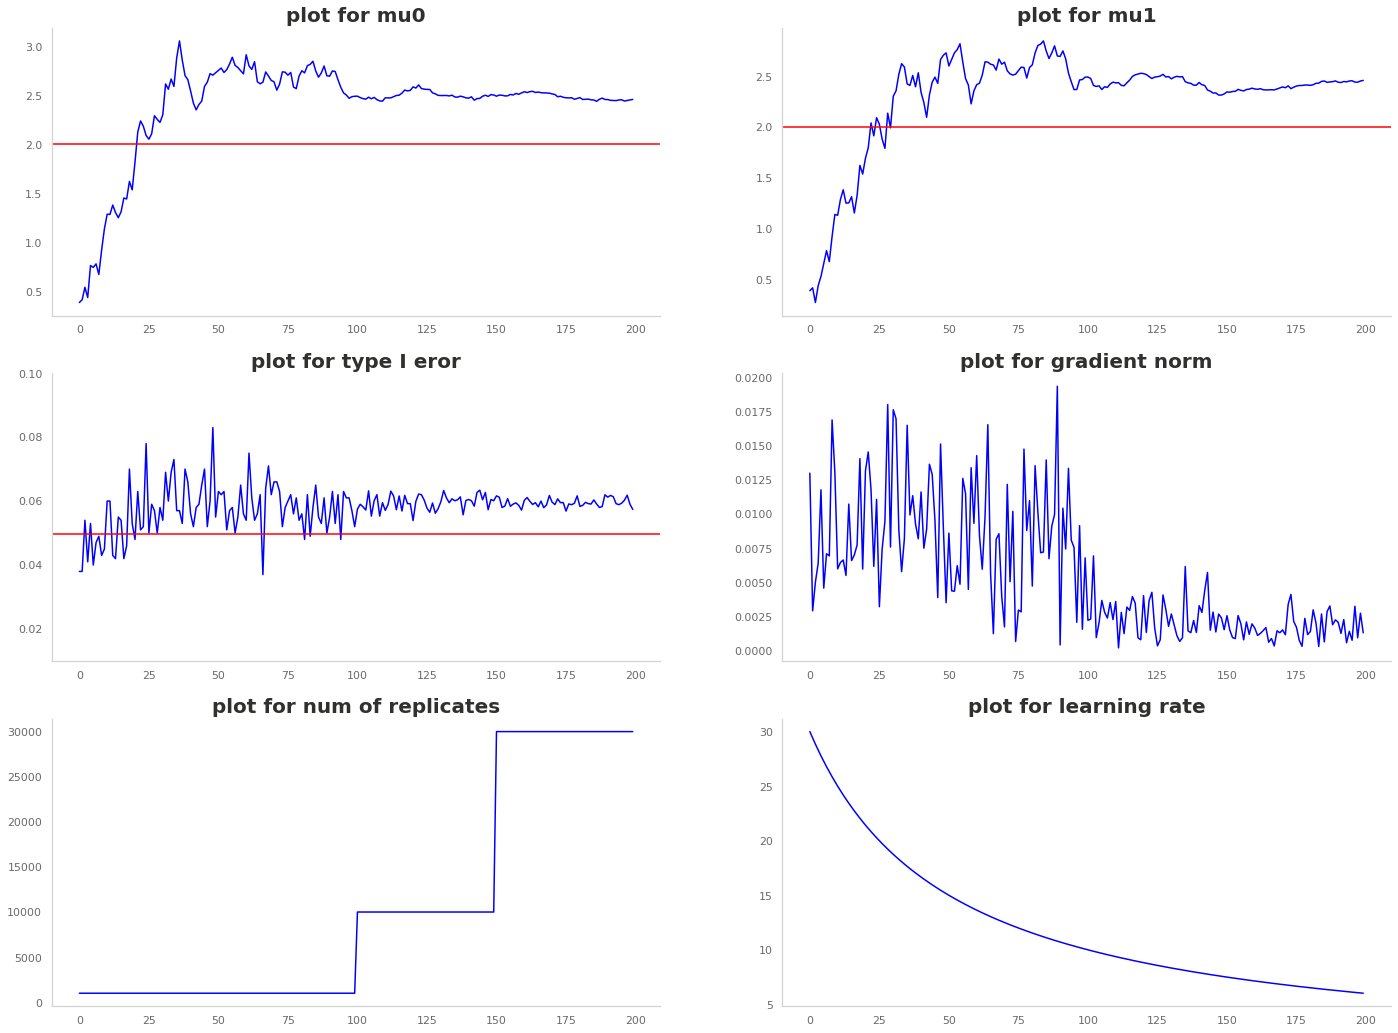

CPU times: user 10.8 s, sys: 27.9 s, total: 38.7 s
Wall time: 5min 9s


In [7]:
%%time
seed(2022)

# def get_pvals(Z_hold, n, r, mu, S, H, N, f = None):
#     if f == None:
#         f = f_fisher
#     XX = Z_hold + mu
#     cond_thres = Vget_cond_thres(XX, n, r)
#     muhat, XXs = Vget_muhat_Xs(XX, n, r)
#     return Vmm_mc_norm(XXs, S, H, f, muhat, cond_thres, N)

m = 4
r = 3
k = r - 1

f = f_bonferroni
N = 500

    
def get_pvals_core(Z_hold, mu):
    XX = Z_hold + mu
    return cpch(XX, m, r, f, pdf=norm.pdf, cdf=norm.cdf, N=N)
def get_grad_core(Z_hold, pvals_hold):
    return  -(Z_hold)[:,:(r-1)]*(pvals_hold <= alpha)[:, np.newaxis]

mu_cur = gen_init(m=m, r=r)
print(f'init at mu={mu_cur}')
mu_seq = []
err_seq = []
gradnorm_seq = [] 
Tmax = 200
lrate0 = 30
lrate_seq = [max(lrate0/(1 + 0.02*tt), 2) for tt in range(Tmax)]
K_seq = []
# lrate_seq = [lrate0*0.95**tt for tt in range()]
for tt in range(Tmax):
    ## exponential decay
    lrate = lrate_seq[tt]
    if tt % 10 == 0:
        print(f'epoch: {tt}, learn rate: {lrate}')
    if tt < 100:
        K = 1e3
        # K = 96*1280
    elif tt < 150:
        K = 1e4
    else:
        K = 3e4#1e5
    K = int(K)
    K_seq.append(K)
    ## shuffle for mini batch
    # Z_mini = normal(scale=1, size=[K, n])
    # X_mini = Z_mini + mu_cur
    # pvals = get_pvals_core(Z_mini, mu_cur)
    # grads = get_grad(n, r, X_mini, mu_cur, pvals, alpha)
    
    Z_list = [normal(scale=1, size=[K//cpus, m]) for _ in range(cpus)]
    Z_all = np.vstack(Z_list)
    star_args = [[Z_list[o], mu_cur] for o in range(cpus)]
    with Pool(processes=cpus) as pool:
        pvals= np.hstack(pool.starmap(get_pvals_core, star_args))
    grads = get_grad_core(Z_all, pvals)
    
    diff = lrate*grads.mean(axis=0)
    mu_cur[:(r-1)] = proj(mu_cur[:(r-1)] - diff)
    mu_seq.append(mu_cur[:(r-1)].copy())
    err_seq.append((pvals <= alpha).mean())
    gradnorm_seq.append(npnorm(grads.mean(axis=0), np.inf))
mu_seq = np.vstack(mu_seq)
print('final epoch error:', err_seq[-1])

print('se cal:', np.sqrt(1/20/K))
print('max type I error:', err_seq[-1], 'at mu =', mu_seq[-1,:])

fig, axs = plt.subplots(3, max(mu_seq.shape[1], 2), figsize = (24, 18))
for i in range(mu_seq.shape[1]):
    _ = axs[0,i].plot(range(mu_seq.shape[0]), mu_seq[:,i], color = 'blue')
    axs[0,i].axhline(y=2, c="red")
    axs[0,i].set_title(f'plot for mu{i}', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,0].plot(range(len(err_seq)), err_seq, color = 'blue')
axs[1,0].axhline(y=0.0496, c="red")
axs[1,0].set_ylim([0.01, 0.1])
axs[1,0].set_title(f'plot for type I eror', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,1].plot(range(len(gradnorm_seq)), gradnorm_seq, color = 'blue')
axs[1,1].set_title(f'plot for gradient norm', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,0].plot(range(len(K_seq)), K_seq, color = 'blue')
axs[2,0].set_title(f'plot for num of replicates', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,1].plot(range(len(lrate_seq)), lrate_seq, color = 'blue')
axs[2,1].set_title(f'plot for learning rate', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
plt.show()

# m=4, r=2

init at mu=[0.04679307 0.         0.         0.        ]
epoch: 0, learn rate: 30.0
epoch: 10, learn rate: 25.0
epoch: 20, learn rate: 21.42857142857143
epoch: 30, learn rate: 18.75
epoch: 40, learn rate: 16.666666666666668
epoch: 50, learn rate: 15.0
epoch: 60, learn rate: 13.636363636363635
epoch: 70, learn rate: 12.499999999999998
epoch: 80, learn rate: 11.538461538461538
epoch: 90, learn rate: 10.714285714285715
epoch: 100, learn rate: 10.0
epoch: 110, learn rate: 9.375
epoch: 120, learn rate: 8.823529411764707
epoch: 130, learn rate: 8.333333333333334
epoch: 140, learn rate: 7.894736842105263
epoch: 150, learn rate: 7.5
epoch: 160, learn rate: 7.142857142857142
epoch: 170, learn rate: 6.8181818181818175
epoch: 180, learn rate: 6.521739130434783
epoch: 190, learn rate: 6.249999999999999
final epoch error: 0.057
se cal: 0.0015811388300841897
max type I error: 0.057 at mu = [2.06896163]


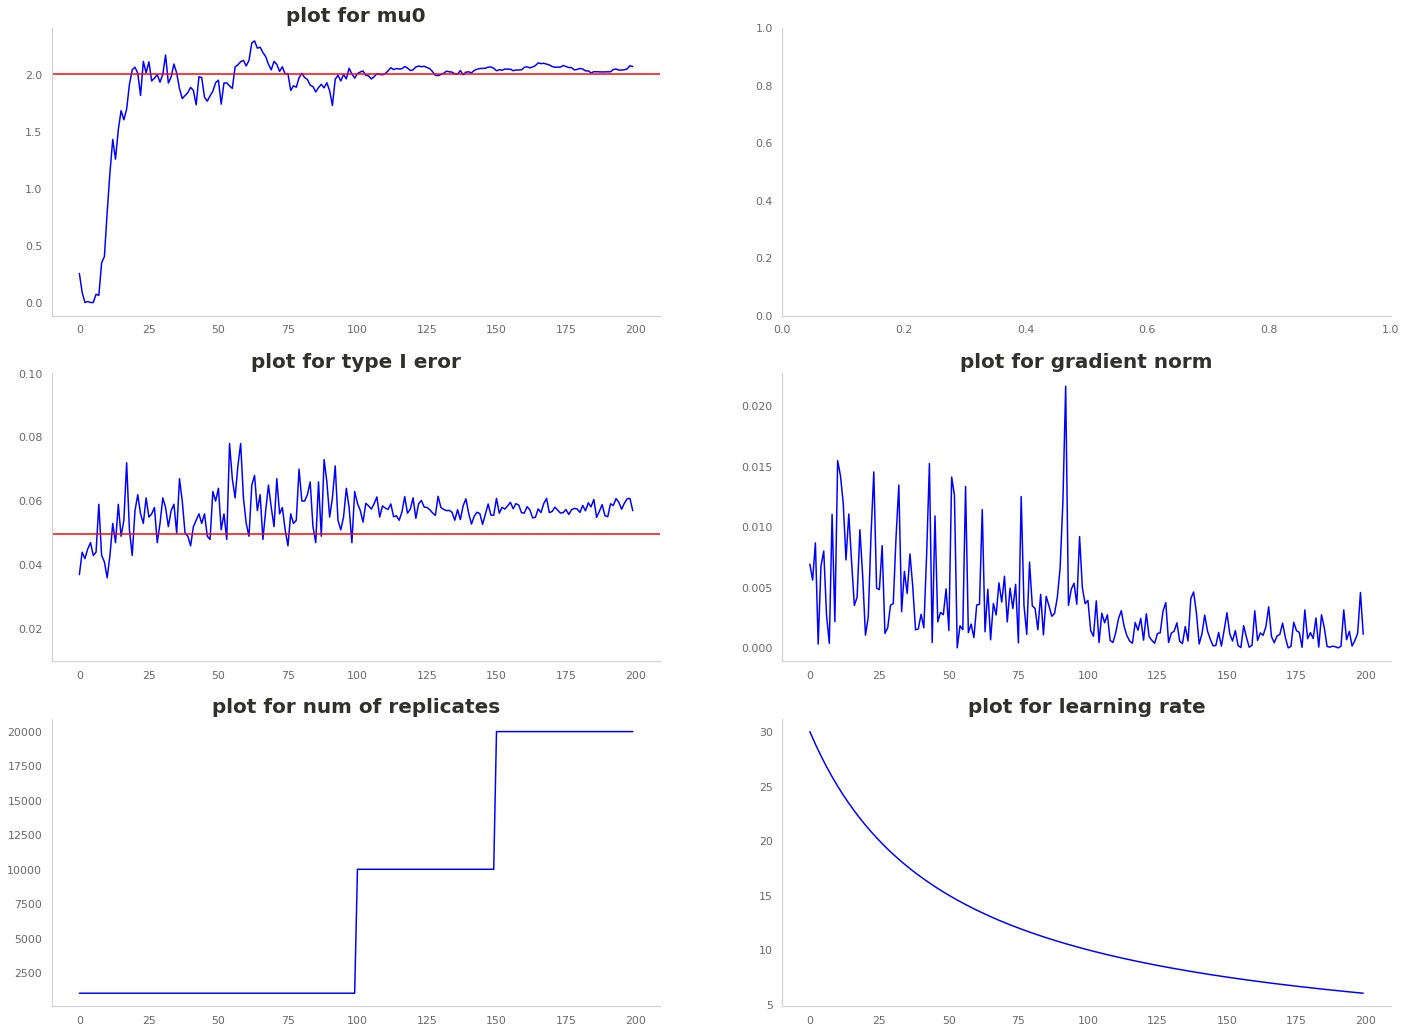

CPU times: user 10.3 s, sys: 27.8 s, total: 38.2 s
Wall time: 2min 27s


In [8]:
%%time
seed(2022)

m = 4
r = 2
k = r - 1

f = f_fisher
N = 500

    
def get_pvals_core(Z_hold, mu):
    XX = Z_hold + mu
    return cpch(XX, m, r, f, pdf=norm.pdf, cdf=norm.cdf, N=N)
def get_grad_core(Z_hold, pvals_hold):
    return  -(Z_hold)[:,:(r-1)]*(pvals_hold <= alpha)[:, np.newaxis]

mu_cur = gen_init(m=m, r=r)
print(f'init at mu={mu_cur}')
mu_seq = []
err_seq = []
gradnorm_seq = [] 
Tmax = 200
lrate0 = 30
lrate_seq = [max(lrate0/(1 + 0.02*tt), 2) for tt in range(Tmax)]
K_seq = []
# lrate_seq = [lrate0*0.95**tt for tt in range()]
for tt in range(Tmax):
    ## exponential decay
    lrate = lrate_seq[tt]
    if tt % 10 == 0:
        print(f'epoch: {tt}, learn rate: {lrate}')
    if tt < 100:
        K = 1e3
        # K = 96*1280
    elif tt < 150:
        K = 1e4
    else:
        K = 2e4#1e5
    K = int(K)
    K_seq.append(K)
    ## shuffle for mini batch
    # Z_mini = normal(scale=1, size=[K, n])
    # X_mini = Z_mini + mu_cur
    # pvals = get_pvals_core(Z_mini, mu_cur)
    # grads = get_grad(n, r, X_mini, mu_cur, pvals, alpha)
    
    Z_list = [normal(scale=1, size=[K//cpus, m]) for _ in range(cpus)]
    Z_all = np.vstack(Z_list)
    star_args = [[Z_list[o], mu_cur] for o in range(cpus)]
    with Pool(processes=cpus) as pool:
        pvals= np.hstack(pool.starmap(get_pvals_core, star_args))
    grads = get_grad_core(Z_all, pvals)
    
    diff = lrate*grads.mean(axis=0)
    mu_cur[:(r-1)] = proj(mu_cur[:(r-1)] - diff)
    mu_seq.append(mu_cur[:(r-1)].copy())
    err_seq.append((pvals <= alpha).mean())
    gradnorm_seq.append(npnorm(grads.mean(axis=0), np.inf))
mu_seq = np.vstack(mu_seq)
print('final epoch error:', err_seq[-1])

print('se cal:', np.sqrt(1/20/K))
print('max type I error:', err_seq[-1], 'at mu =', mu_seq[-1,:])

fig, axs = plt.subplots(3, max(mu_seq.shape[1], 2), figsize = (24, 18))
for i in range(mu_seq.shape[1]):
    _ = axs[0,i].plot(range(mu_seq.shape[0]), mu_seq[:,i], color = 'blue')
    axs[0,i].axhline(y=2, c="red")
    axs[0,i].set_title(f'plot for mu{i}', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,0].plot(range(len(err_seq)), err_seq, color = 'blue')
axs[1,0].axhline(y=0.0496, c="red")
axs[1,0].set_ylim([0.01, 0.1])
axs[1,0].set_title(f'plot for type I eror', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,1].plot(range(len(gradnorm_seq)), gradnorm_seq, color = 'blue')
axs[1,1].set_title(f'plot for gradient norm', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,0].plot(range(len(K_seq)), K_seq, color = 'blue')
axs[2,0].set_title(f'plot for num of replicates', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,1].plot(range(len(lrate_seq)), lrate_seq, color = 'blue')
axs[2,1].set_title(f'plot for learning rate', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
plt.show()

init at mu=[0.04679307 0.         0.         0.        ]
epoch: 0, learn rate: 30.0
epoch: 10, learn rate: 25.0
epoch: 20, learn rate: 21.42857142857143
epoch: 30, learn rate: 18.75
epoch: 40, learn rate: 16.666666666666668
epoch: 50, learn rate: 15.0
epoch: 60, learn rate: 13.636363636363635
epoch: 70, learn rate: 12.499999999999998
epoch: 80, learn rate: 11.538461538461538
epoch: 90, learn rate: 10.714285714285715
epoch: 100, learn rate: 10.0
epoch: 110, learn rate: 9.375
epoch: 120, learn rate: 8.823529411764707
epoch: 130, learn rate: 8.333333333333334
epoch: 140, learn rate: 7.894736842105263
epoch: 150, learn rate: 7.5
epoch: 160, learn rate: 7.142857142857142
epoch: 170, learn rate: 6.8181818181818175
epoch: 180, learn rate: 6.521739130434783
epoch: 190, learn rate: 6.249999999999999
final epoch error: 0.05865
se cal: 0.0015811388300841897
max type I error: 0.05865 at mu = [2.23690454]


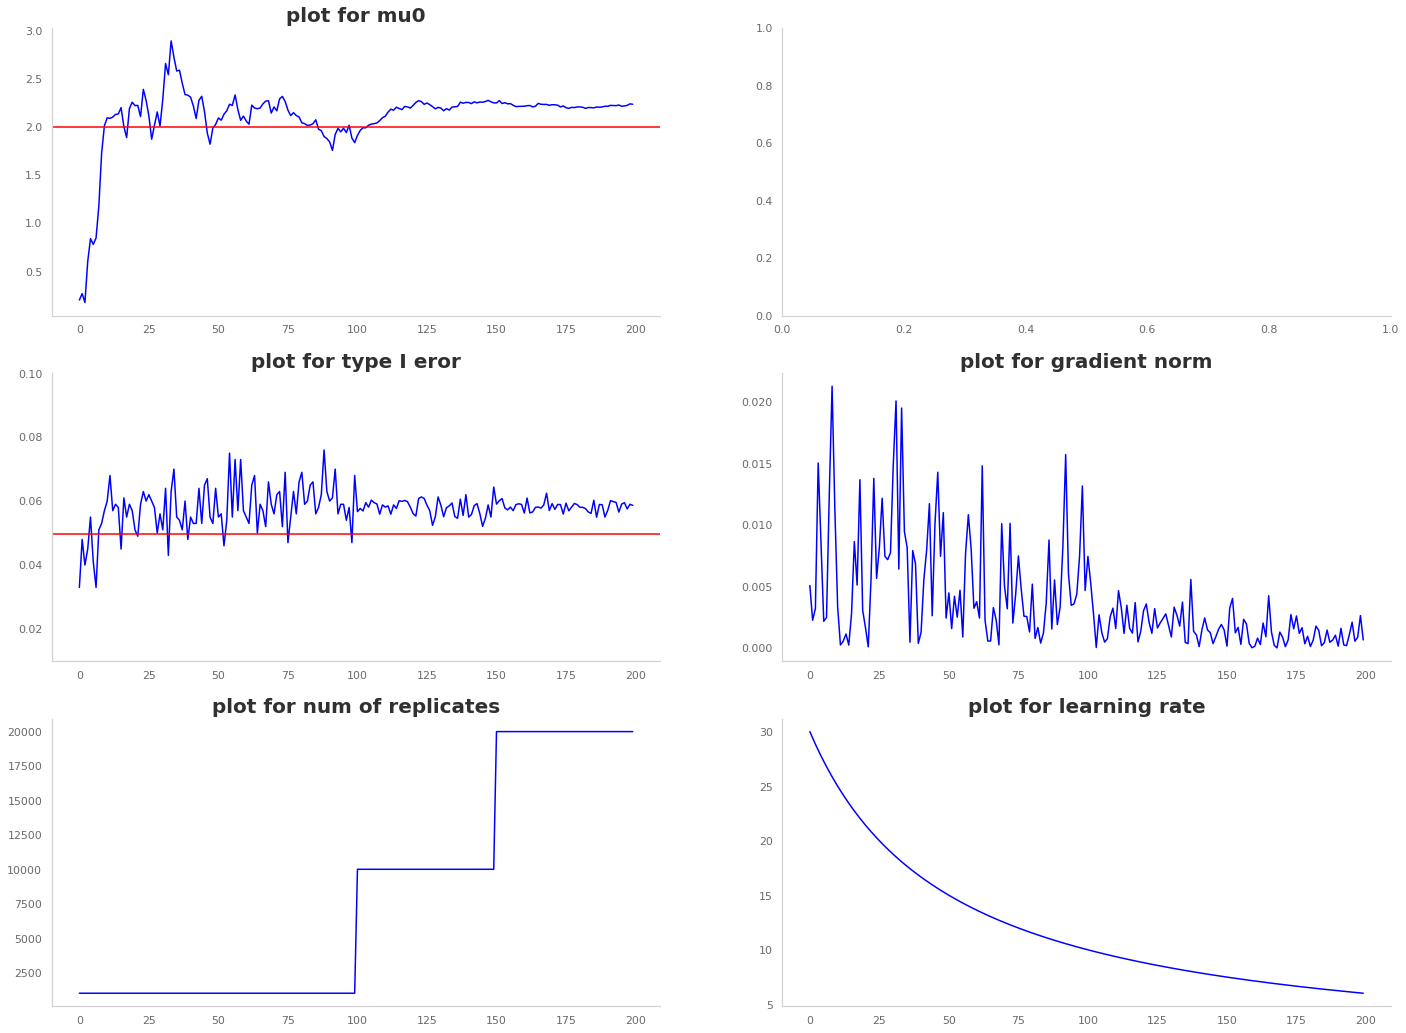

CPU times: user 10.4 s, sys: 29.7 s, total: 40.1 s
Wall time: 2min 29s


In [9]:
%%time
seed(2022)

# def get_pvals(Z_hold, n, r, mu, S, H, N, f = None):
#     if f == None:
#         f = f_fisher
#     XX = Z_hold + mu
#     cond_thres = Vget_cond_thres(XX, n, r)
#     muhat, XXs = Vget_muhat_Xs(XX, n, r)
#     return Vmm_mc_norm(XXs, S, H, f, muhat, cond_thres, N)

m = 4
r = 2
k = r - 1

f = f_simes
N = 500

    
def get_pvals_core(Z_hold, mu):
    XX = Z_hold + mu
    return cpch(XX, m, r, f, pdf=norm.pdf, cdf=norm.cdf, N=N)
def get_grad_core(Z_hold, pvals_hold):
    return  -(Z_hold)[:,:(r-1)]*(pvals_hold <= alpha)[:, np.newaxis]

mu_cur = gen_init(m=m, r=r)
print(f'init at mu={mu_cur}')
mu_seq = []
err_seq = []
gradnorm_seq = [] 
Tmax = 200
lrate0 = 30
lrate_seq = [max(lrate0/(1 + 0.02*tt), 2) for tt in range(Tmax)]
K_seq = []
# lrate_seq = [lrate0*0.95**tt for tt in range()]
for tt in range(Tmax):
    ## exponential decay
    lrate = lrate_seq[tt]
    if tt % 10 == 0:
        print(f'epoch: {tt}, learn rate: {lrate}')
    if tt < 100:
        K = 1e3
        # K = 96*1280
    elif tt < 150:
        K = 1e4
    else:
        K = 2e4#1e5
    K = int(K)
    K_seq.append(K)
    ## shuffle for mini batch
    # Z_mini = normal(scale=1, size=[K, n])
    # X_mini = Z_mini + mu_cur
    # pvals = get_pvals_core(Z_mini, mu_cur)
    # grads = get_grad(n, r, X_mini, mu_cur, pvals, alpha)
    
    Z_list = [normal(scale=1, size=[K//cpus, m]) for _ in range(cpus)]
    Z_all = np.vstack(Z_list)
    star_args = [[Z_list[o], mu_cur] for o in range(cpus)]
    with Pool(processes=cpus) as pool:
        pvals= np.hstack(pool.starmap(get_pvals_core, star_args))
    grads = get_grad_core(Z_all, pvals)
    
    diff = lrate*grads.mean(axis=0)
    mu_cur[:(r-1)] = proj(mu_cur[:(r-1)] - diff)
    mu_seq.append(mu_cur[:(r-1)].copy())
    err_seq.append((pvals <= alpha).mean())
    gradnorm_seq.append(npnorm(grads.mean(axis=0), np.inf))
mu_seq = np.vstack(mu_seq)
print('final epoch error:', err_seq[-1])

print('se cal:', np.sqrt(1/20/K))
print('max type I error:', err_seq[-1], 'at mu =', mu_seq[-1,:])

fig, axs = plt.subplots(3, max(mu_seq.shape[1], 2), figsize = (24, 18))
for i in range(mu_seq.shape[1]):
    _ = axs[0,i].plot(range(mu_seq.shape[0]), mu_seq[:,i], color = 'blue')
    axs[0,i].axhline(y=2, c="red")
    axs[0,i].set_title(f'plot for mu{i}', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,0].plot(range(len(err_seq)), err_seq, color = 'blue')
axs[1,0].axhline(y=0.0496, c="red")
axs[1,0].set_ylim([0.01, 0.1])
axs[1,0].set_title(f'plot for type I eror', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,1].plot(range(len(gradnorm_seq)), gradnorm_seq, color = 'blue')
axs[1,1].set_title(f'plot for gradient norm', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,0].plot(range(len(K_seq)), K_seq, color = 'blue')
axs[2,0].set_title(f'plot for num of replicates', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,1].plot(range(len(lrate_seq)), lrate_seq, color = 'blue')
axs[2,1].set_title(f'plot for learning rate', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
plt.show()

init at mu=[0.04679307 0.         0.         0.        ]
epoch: 0, learn rate: 30.0
epoch: 10, learn rate: 25.0
epoch: 20, learn rate: 21.42857142857143
epoch: 30, learn rate: 18.75
epoch: 40, learn rate: 16.666666666666668
epoch: 50, learn rate: 15.0
epoch: 60, learn rate: 13.636363636363635
epoch: 70, learn rate: 12.499999999999998
epoch: 80, learn rate: 11.538461538461538
epoch: 90, learn rate: 10.714285714285715
epoch: 100, learn rate: 10.0
epoch: 110, learn rate: 9.375
epoch: 120, learn rate: 8.823529411764707
epoch: 130, learn rate: 8.333333333333334
epoch: 140, learn rate: 7.894736842105263
epoch: 150, learn rate: 7.5
epoch: 160, learn rate: 7.142857142857142
epoch: 170, learn rate: 6.8181818181818175
epoch: 180, learn rate: 6.521739130434783
epoch: 190, learn rate: 6.249999999999999
final epoch error: 0.05755
se cal: 0.0015811388300841897
max type I error: 0.05755 at mu = [2.31931988]


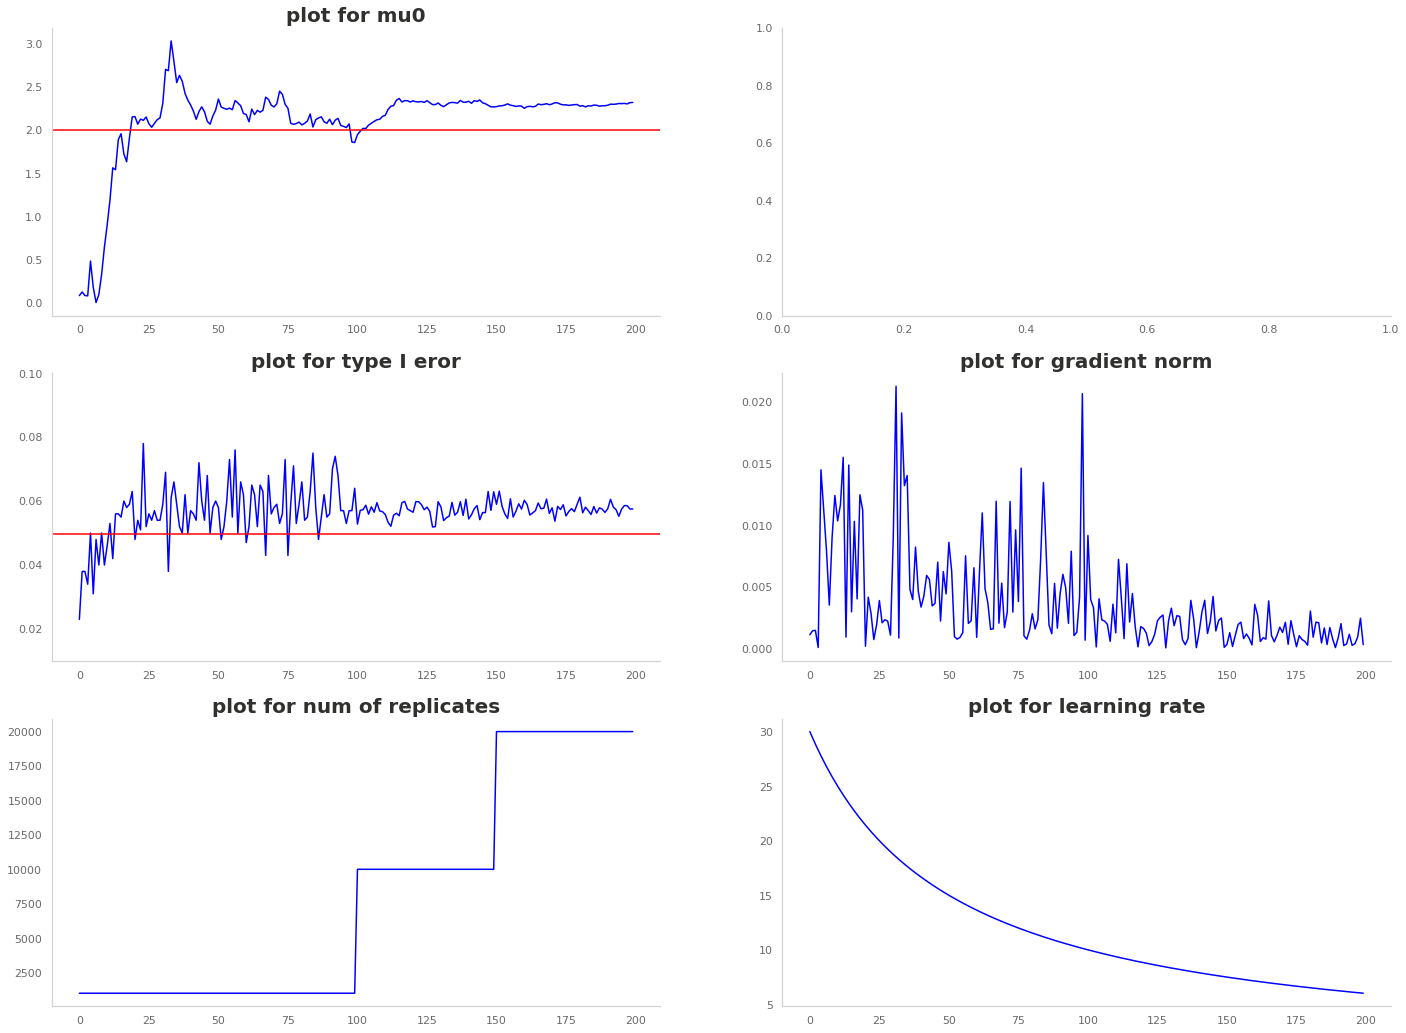

CPU times: user 10 s, sys: 30.5 s, total: 40.6 s
Wall time: 2min 27s


In [10]:
%%time
seed(2022)

m = 4
r = 2
k = r - 1

f = f_bonferroni
N = 500

    
def get_pvals_core(Z_hold, mu):
    XX = Z_hold + mu
    return cpch(XX, m, r, f, pdf=norm.pdf, cdf=norm.cdf, N=N)
def get_grad_core(Z_hold, pvals_hold):
    return  -(Z_hold)[:,:(r-1)]*(pvals_hold <= alpha)[:, np.newaxis]

mu_cur = gen_init(m=m, r=r)
print(f'init at mu={mu_cur}')
mu_seq = []
err_seq = []
gradnorm_seq = [] 
Tmax = 200
lrate0 = 30
lrate_seq = [max(lrate0/(1 + 0.02*tt), 2) for tt in range(Tmax)]
K_seq = []
# lrate_seq = [lrate0*0.95**tt for tt in range()]
for tt in range(Tmax):
    ## exponential decay
    lrate = lrate_seq[tt]
    if tt % 10 == 0:
        print(f'epoch: {tt}, learn rate: {lrate}')
    if tt < 100:
        K = 1e3
        # K = 96*1280
    elif tt < 150:
        K = 1e4
    else:
        K = 2e4#1e5
    K = int(K)
    K_seq.append(K)
    ## shuffle for mini batch
    # Z_mini = normal(scale=1, size=[K, n])
    # X_mini = Z_mini + mu_cur
    # pvals = get_pvals_core(Z_mini, mu_cur)
    # grads = get_grad(n, r, X_mini, mu_cur, pvals, alpha)
    
    Z_list = [normal(scale=1, size=[K//cpus, m]) for _ in range(cpus)]
    Z_all = np.vstack(Z_list)
    star_args = [[Z_list[o], mu_cur] for o in range(cpus)]
    with Pool(processes=cpus) as pool:
        pvals= np.hstack(pool.starmap(get_pvals_core, star_args))
    grads = get_grad_core(Z_all, pvals)
    
    diff = lrate*grads.mean(axis=0)
    mu_cur[:(r-1)] = proj(mu_cur[:(r-1)] - diff)
    mu_seq.append(mu_cur[:(r-1)].copy())
    err_seq.append((pvals <= alpha).mean())
    gradnorm_seq.append(npnorm(grads.mean(axis=0), np.inf))
mu_seq = np.vstack(mu_seq)
print('final epoch error:', err_seq[-1])

print('se cal:', np.sqrt(1/20/K))
print('max type I error:', err_seq[-1], 'at mu =', mu_seq[-1,:])

fig, axs = plt.subplots(3, max(mu_seq.shape[1], 2), figsize = (24, 18))
for i in range(mu_seq.shape[1]):
    _ = axs[0,i].plot(range(mu_seq.shape[0]), mu_seq[:,i], color = 'blue')
    axs[0,i].axhline(y=2, c="red")
    axs[0,i].set_title(f'plot for mu{i}', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,0].plot(range(len(err_seq)), err_seq, color = 'blue')
axs[1,0].axhline(y=0.0496, c="red")
axs[1,0].set_ylim([0.01, 0.1])
axs[1,0].set_title(f'plot for type I eror', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,1].plot(range(len(gradnorm_seq)), gradnorm_seq, color = 'blue')
axs[1,1].set_title(f'plot for gradient norm', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,0].plot(range(len(K_seq)), K_seq, color = 'blue')
axs[2,0].set_title(f'plot for num of replicates', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,1].plot(range(len(lrate_seq)), lrate_seq, color = 'blue')
axs[2,1].set_title(f'plot for learning rate', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
plt.show()

# m=r=4

init at mu=[0.04679307 0.02335245 0.00264779 0.        ]
epoch: 0, learn rate: 30.0
epoch: 10, learn rate: 25.0
epoch: 20, learn rate: 21.42857142857143
epoch: 30, learn rate: 18.75
epoch: 40, learn rate: 16.666666666666668
epoch: 50, learn rate: 15.0
epoch: 60, learn rate: 13.636363636363635
epoch: 70, learn rate: 12.499999999999998
epoch: 80, learn rate: 11.538461538461538
epoch: 90, learn rate: 10.714285714285715
epoch: 100, learn rate: 10.0
epoch: 110, learn rate: 9.375
epoch: 120, learn rate: 8.823529411764707
epoch: 130, learn rate: 8.333333333333334
epoch: 140, learn rate: 7.894736842105263
epoch: 150, learn rate: 7.5
epoch: 160, learn rate: 7.142857142857142
epoch: 170, learn rate: 6.8181818181818175
epoch: 180, learn rate: 6.521739130434783
epoch: 190, learn rate: 6.249999999999999
final epoch error: 0.062266666666666665
se cal: 0.0012909944487358056
max type I error: 0.062266666666666665 at mu = [2.59551089 2.45401534 2.4292473 ]


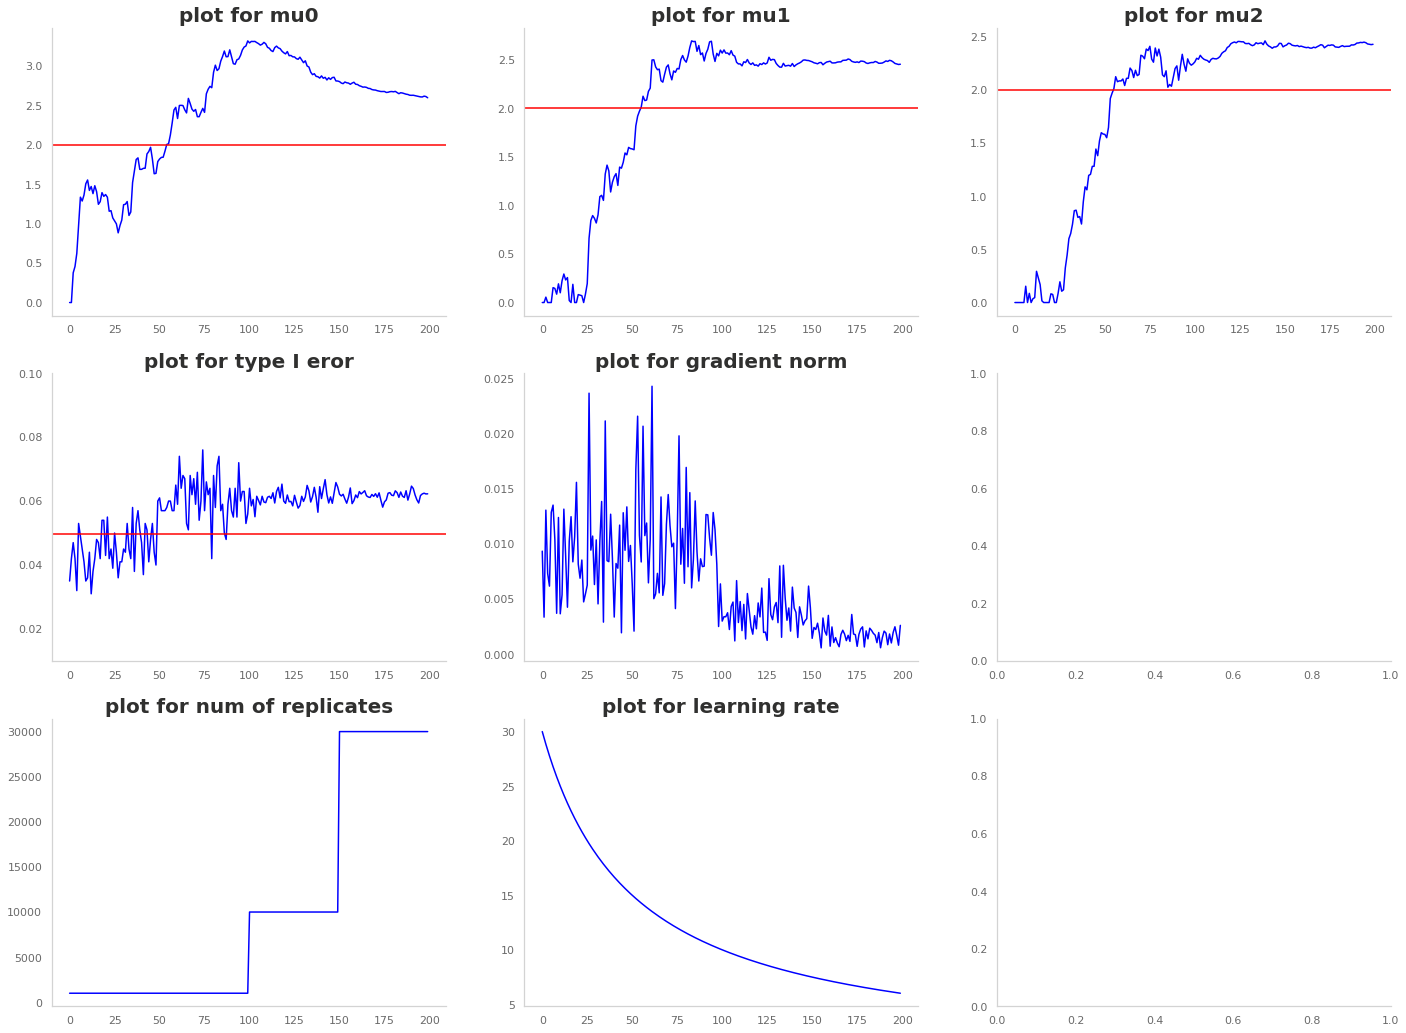

CPU times: user 10.9 s, sys: 30.2 s, total: 41.1 s
Wall time: 3min 5s


In [11]:
%%time
seed(2022)

m = 4
r = 4
k = r - 1

f = f_bonferroni
N = 500

    
def get_pvals_core(Z_hold, mu):
    XX = Z_hold + mu
    return cpch(XX, m, r, f, pdf=norm.pdf, cdf=norm.cdf, N=N)
def get_grad_core(Z_hold, pvals_hold):
    return  -(Z_hold)[:,:(r-1)]*(pvals_hold <= alpha)[:, np.newaxis]

mu_cur = gen_init(m=m, r=r)
print(f'init at mu={mu_cur}')
mu_seq = []
err_seq = []
gradnorm_seq = [] 
Tmax = 200
lrate0 = 50
lrate_seq = [max(lrate0/(1 + 0.02*tt), 2) for tt in range(Tmax)]
K_seq = []
# lrate_seq = [lrate0*0.95**tt for tt in range()]
for tt in range(Tmax):
    ## exponential decay
    lrate = lrate_seq[tt]
    if tt % 10 == 0:
        print(f'epoch: {tt}, learn rate: {lrate}')
    if tt < 100:
        K = 1e3
        # K = 96*1280
    elif tt < 150:
        K = 1e4
    else:
        K = 3e4#1e5
    K = int(K)
    K_seq.append(K)
    ## shuffle for mini batch
    # Z_mini = normal(scale=1, size=[K, n])
    # X_mini = Z_mini + mu_cur
    # pvals = get_pvals_core(Z_mini, mu_cur)
    # grads = get_grad(n, r, X_mini, mu_cur, pvals, alpha)
    
    Z_list = [normal(scale=1, size=[K//cpus, m]) for _ in range(cpus)]
    Z_all = np.vstack(Z_list)
    star_args = [[Z_list[o], mu_cur] for o in range(cpus)]
    with Pool(processes=cpus) as pool:
        pvals= np.hstack(pool.starmap(get_pvals_core, star_args))
    grads = get_grad_core(Z_all, pvals)
    
    diff = lrate*grads.mean(axis=0)
    mu_cur[:(r-1)] = proj(mu_cur[:(r-1)] - diff)
    mu_seq.append(mu_cur[:(r-1)].copy())
    err_seq.append((pvals <= alpha).mean())
    gradnorm_seq.append(npnorm(grads.mean(axis=0), np.inf))
mu_seq = np.vstack(mu_seq)
print('final epoch error:', err_seq[-1])

print('se cal:', np.sqrt(1/20/K))
print('max type I error:', err_seq[-1], 'at mu =', mu_seq[-1,:])

fig, axs = plt.subplots(3, max(mu_seq.shape[1], 2), figsize = (24, 18))
for i in range(mu_seq.shape[1]):
    _ = axs[0,i].plot(range(mu_seq.shape[0]), mu_seq[:,i], color = 'blue')
    axs[0,i].axhline(y=2, c="red")
    axs[0,i].set_title(f'plot for mu{i}', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,0].plot(range(len(err_seq)), err_seq, color = 'blue')
axs[1,0].axhline(y=0.0496, c="red")
axs[1,0].set_ylim([0.01, 0.1])
axs[1,0].set_title(f'plot for type I eror', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,1].plot(range(len(gradnorm_seq)), gradnorm_seq, color = 'blue')
axs[1,1].set_title(f'plot for gradient norm', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,0].plot(range(len(K_seq)), K_seq, color = 'blue')
axs[2,0].set_title(f'plot for num of replicates', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,1].plot(range(len(lrate_seq)), lrate_seq, color = 'blue')
axs[2,1].set_title(f'plot for learning rate', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
plt.show()

# m=3, r=2

init at mu=[0.04679307 0.         0.        ]
epoch: 0, learn rate: 30.0
epoch: 10, learn rate: 25.0
epoch: 20, learn rate: 21.42857142857143
epoch: 30, learn rate: 18.75
epoch: 40, learn rate: 16.666666666666668
epoch: 50, learn rate: 15.0
epoch: 60, learn rate: 13.636363636363635
epoch: 70, learn rate: 12.499999999999998
epoch: 80, learn rate: 11.538461538461538
epoch: 90, learn rate: 10.714285714285715
epoch: 100, learn rate: 10.0
epoch: 110, learn rate: 9.375
epoch: 120, learn rate: 8.823529411764707
epoch: 130, learn rate: 8.333333333333334
epoch: 140, learn rate: 7.894736842105263
epoch: 150, learn rate: 7.5
epoch: 160, learn rate: 7.142857142857142
epoch: 170, learn rate: 6.8181818181818175
epoch: 180, learn rate: 6.521739130434783
epoch: 190, learn rate: 6.249999999999999
final epoch error: 0.05823333333333333
se cal: 0.0012909944487358056
max type I error: 0.05823333333333333 at mu = [2.09110199]


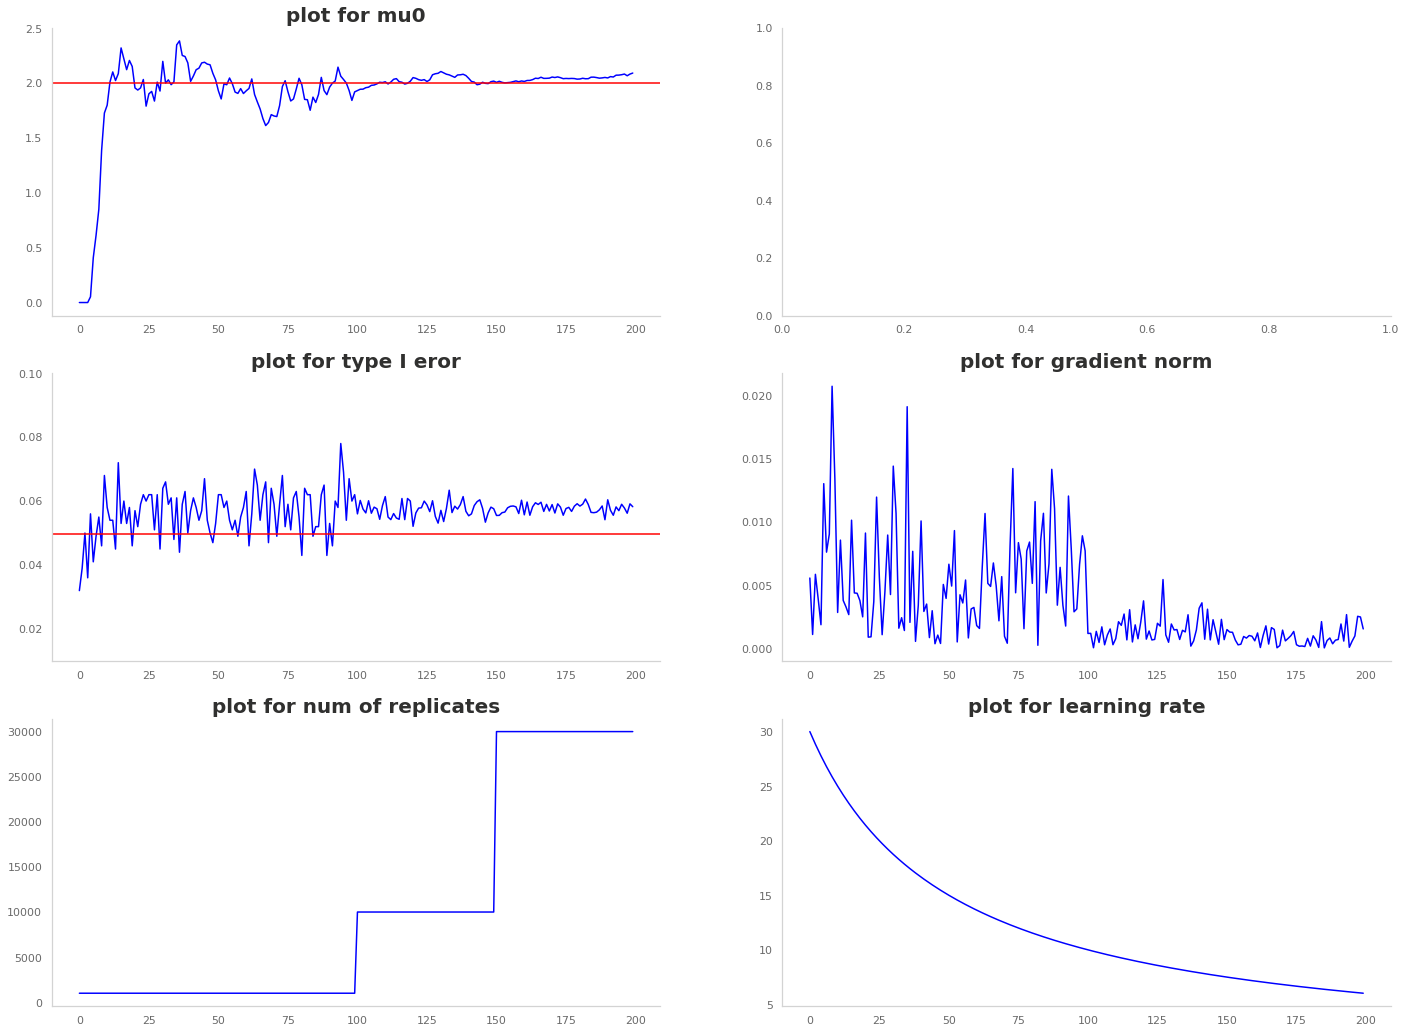

CPU times: user 9.89 s, sys: 32.1 s, total: 42 s
Wall time: 1min 50s


In [12]:
%%time
seed(2022)

m = 3
r = 2
k = r - 1

f = f_fisher
N = 500

    
def get_pvals_core(Z_hold, mu):
    XX = Z_hold + mu
    return cpch(XX, m, r, f, pdf=norm.pdf, cdf=norm.cdf, N=N)
def get_grad_core(Z_hold, pvals_hold):
    return  -(Z_hold)[:,:(r-1)]*(pvals_hold <= alpha)[:, np.newaxis]

mu_cur = gen_init(m=m, r=r)
print(f'init at mu={mu_cur}')
mu_seq = []
err_seq = []
gradnorm_seq = [] 
Tmax = 200
lrate0 = 30
lrate_seq = [max(lrate0/(1 + 0.02*tt), 2) for tt in range(Tmax)]
K_seq = []
# lrate_seq = [lrate0*0.95**tt for tt in range()]
for tt in range(Tmax):
    ## exponential decay
    lrate = lrate_seq[tt]
    if tt % 10 == 0:
        print(f'epoch: {tt}, learn rate: {lrate}')
    if tt < 100:
        K = 1e3
        # K = 96*1280
    elif tt < 150:
        K = 1e4
    else:
        K = 3e4#1e5
    K = int(K)
    K_seq.append(K)
    ## shuffle for mini batch
    # Z_mini = normal(scale=1, size=[K, n])
    # X_mini = Z_mini + mu_cur
    # pvals = get_pvals_core(Z_mini, mu_cur)
    # grads = get_grad(n, r, X_mini, mu_cur, pvals, alpha)
    
    Z_list = [normal(scale=1, size=[K//cpus, m]) for _ in range(cpus)]
    Z_all = np.vstack(Z_list)
    star_args = [[Z_list[o], mu_cur] for o in range(cpus)]
    with Pool(processes=cpus) as pool:
        pvals= np.hstack(pool.starmap(get_pvals_core, star_args))
    grads = get_grad_core(Z_all, pvals)
    
    diff = lrate*grads.mean(axis=0)
    mu_cur[:(r-1)] = proj(mu_cur[:(r-1)] - diff)
    mu_seq.append(mu_cur[:(r-1)].copy())
    err_seq.append((pvals <= alpha).mean())
    gradnorm_seq.append(npnorm(grads.mean(axis=0), np.inf))
mu_seq = np.vstack(mu_seq)
print('final epoch error:', err_seq[-1])

print('se cal:', np.sqrt(1/20/K))
print('max type I error:', err_seq[-1], 'at mu =', mu_seq[-1,:])

fig, axs = plt.subplots(3, max(mu_seq.shape[1], 2), figsize = (24, 18))
for i in range(mu_seq.shape[1]):
    _ = axs[0,i].plot(range(mu_seq.shape[0]), mu_seq[:,i], color = 'blue')
    axs[0,i].axhline(y=2, c="red")
    axs[0,i].set_title(f'plot for mu{i}', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,0].plot(range(len(err_seq)), err_seq, color = 'blue')
axs[1,0].axhline(y=0.0496, c="red")
axs[1,0].set_ylim([0.01, 0.1])
axs[1,0].set_title(f'plot for type I eror', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,1].plot(range(len(gradnorm_seq)), gradnorm_seq, color = 'blue')
axs[1,1].set_title(f'plot for gradient norm', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,0].plot(range(len(K_seq)), K_seq, color = 'blue')
axs[2,0].set_title(f'plot for num of replicates', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,1].plot(range(len(lrate_seq)), lrate_seq, color = 'blue')
axs[2,1].set_title(f'plot for learning rate', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
plt.show()

init at mu=[0.04679307 0.         0.        ]
epoch: 0, learn rate: 30.0
epoch: 10, learn rate: 25.0
epoch: 20, learn rate: 21.42857142857143
epoch: 30, learn rate: 18.75
epoch: 40, learn rate: 16.666666666666668
epoch: 50, learn rate: 15.0
epoch: 60, learn rate: 13.636363636363635
epoch: 70, learn rate: 12.499999999999998
epoch: 80, learn rate: 11.538461538461538
epoch: 90, learn rate: 10.714285714285715
epoch: 100, learn rate: 10.0
epoch: 110, learn rate: 9.375
epoch: 120, learn rate: 8.823529411764707
epoch: 130, learn rate: 8.333333333333334
epoch: 140, learn rate: 7.894736842105263
epoch: 150, learn rate: 7.5
epoch: 160, learn rate: 7.142857142857142
epoch: 170, learn rate: 6.8181818181818175
epoch: 180, learn rate: 6.521739130434783
epoch: 190, learn rate: 6.249999999999999
final epoch error: 0.05856666666666667
se cal: 0.0012909944487358056
max type I error: 0.05856666666666667 at mu = [2.18373833]


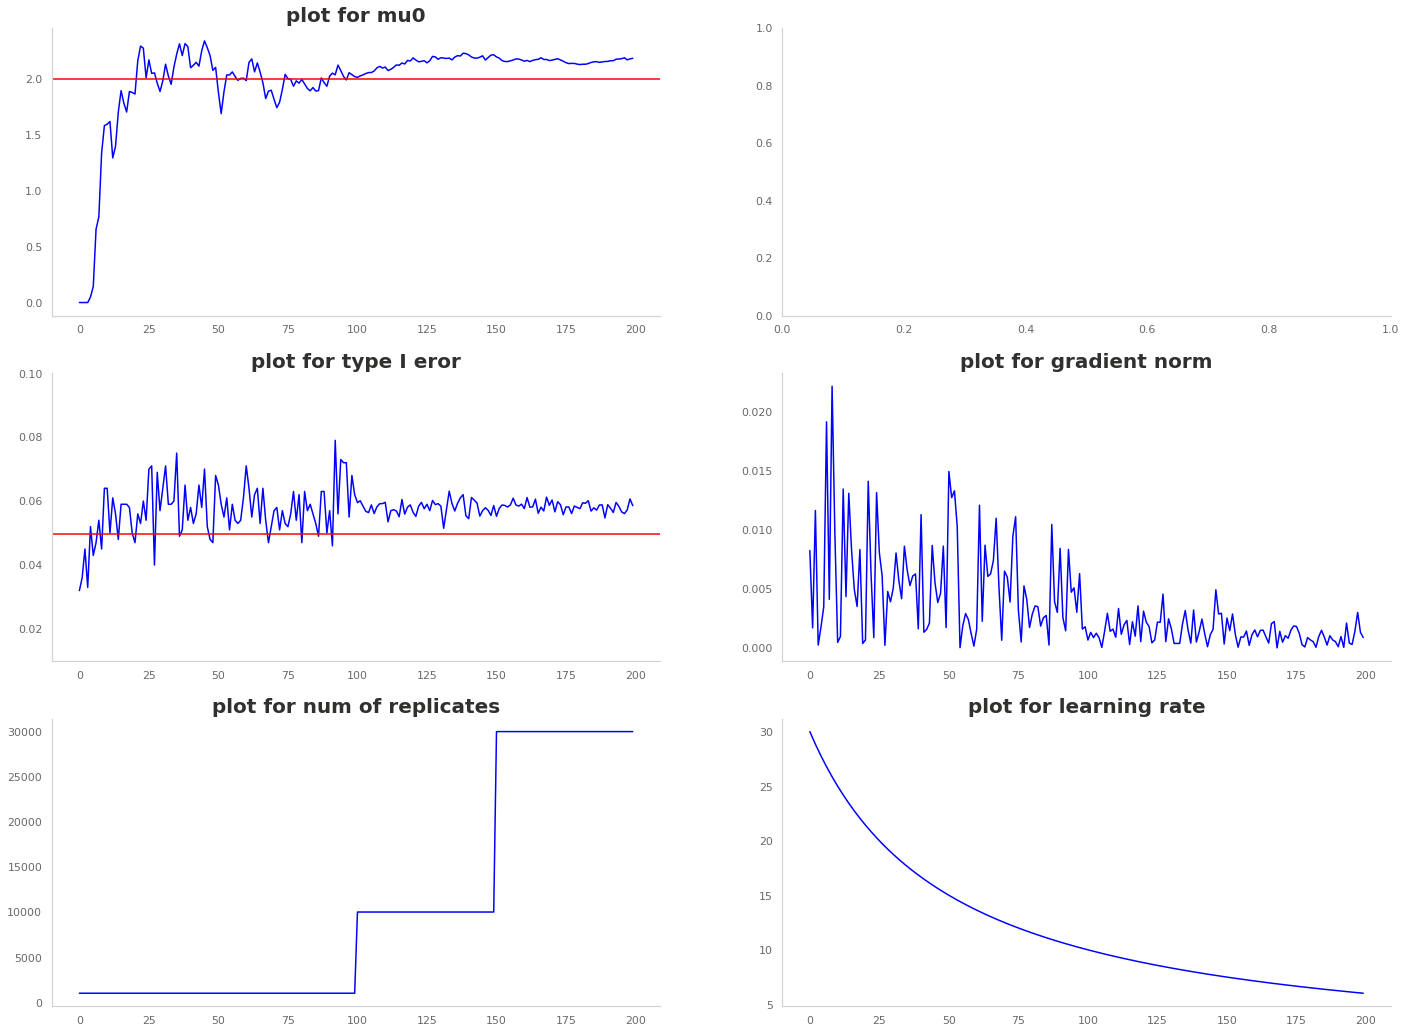

CPU times: user 9.72 s, sys: 31.8 s, total: 41.5 s
Wall time: 1min 52s


In [13]:
%%time
seed(2022)

m = 3
r = 2
k = r - 1

f = f_simes
N = 500

    
def get_pvals_core(Z_hold, mu):
    XX = Z_hold + mu
    return cpch(XX, m, r, f, pdf=norm.pdf, cdf=norm.cdf, N=N)
def get_grad_core(Z_hold, pvals_hold):
    return  -(Z_hold)[:,:(r-1)]*(pvals_hold <= alpha)[:, np.newaxis]

mu_cur = gen_init(m=m, r=r)
print(f'init at mu={mu_cur}')
mu_seq = []
err_seq = []
gradnorm_seq = [] 
Tmax = 200
lrate0 = 30
lrate_seq = [max(lrate0/(1 + 0.02*tt), 2) for tt in range(Tmax)]
K_seq = []
# lrate_seq = [lrate0*0.95**tt for tt in range()]
for tt in range(Tmax):
    ## exponential decay
    lrate = lrate_seq[tt]
    if tt % 10 == 0:
        print(f'epoch: {tt}, learn rate: {lrate}')
    if tt < 100:
        K = 1e3
        # K = 96*1280
    elif tt < 150:
        K = 1e4
    else:
        K = 3e4#1e5
    K = int(K)
    K_seq.append(K)
    ## shuffle for mini batch
    # Z_mini = normal(scale=1, size=[K, n])
    # X_mini = Z_mini + mu_cur
    # pvals = get_pvals_core(Z_mini, mu_cur)
    # grads = get_grad(n, r, X_mini, mu_cur, pvals, alpha)
    
    Z_list = [normal(scale=1, size=[K//cpus, m]) for _ in range(cpus)]
    Z_all = np.vstack(Z_list)
    star_args = [[Z_list[o], mu_cur] for o in range(cpus)]
    with Pool(processes=cpus) as pool:
        pvals= np.hstack(pool.starmap(get_pvals_core, star_args))
    grads = get_grad_core(Z_all, pvals)
    
    diff = lrate*grads.mean(axis=0)
    mu_cur[:(r-1)] = proj(mu_cur[:(r-1)] - diff)
    mu_seq.append(mu_cur[:(r-1)].copy())
    err_seq.append((pvals <= alpha).mean())
    gradnorm_seq.append(npnorm(grads.mean(axis=0), np.inf))
mu_seq = np.vstack(mu_seq)
print('final epoch error:', err_seq[-1])

print('se cal:', np.sqrt(1/20/K))
print('max type I error:', err_seq[-1], 'at mu =', mu_seq[-1,:])

fig, axs = plt.subplots(3, max(mu_seq.shape[1], 2), figsize = (24, 18))
for i in range(mu_seq.shape[1]):
    _ = axs[0,i].plot(range(mu_seq.shape[0]), mu_seq[:,i], color = 'blue')
    axs[0,i].axhline(y=2, c="red")
    axs[0,i].set_title(f'plot for mu{i}', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,0].plot(range(len(err_seq)), err_seq, color = 'blue')
axs[1,0].axhline(y=0.0496, c="red")
axs[1,0].set_ylim([0.01, 0.1])
axs[1,0].set_title(f'plot for type I eror', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,1].plot(range(len(gradnorm_seq)), gradnorm_seq, color = 'blue')
axs[1,1].set_title(f'plot for gradient norm', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,0].plot(range(len(K_seq)), K_seq, color = 'blue')
axs[2,0].set_title(f'plot for num of replicates', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,1].plot(range(len(lrate_seq)), lrate_seq, color = 'blue')
axs[2,1].set_title(f'plot for learning rate', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
plt.show()

init at mu=[0.04679307 0.         0.        ]
epoch: 0, learn rate: 30.0
epoch: 10, learn rate: 25.0
epoch: 20, learn rate: 21.42857142857143
epoch: 30, learn rate: 18.75
epoch: 40, learn rate: 16.666666666666668
epoch: 50, learn rate: 15.0
epoch: 60, learn rate: 13.636363636363635
epoch: 70, learn rate: 12.499999999999998
epoch: 80, learn rate: 11.538461538461538
epoch: 90, learn rate: 10.714285714285715
epoch: 100, learn rate: 10.0
epoch: 110, learn rate: 9.375
epoch: 120, learn rate: 8.823529411764707
epoch: 130, learn rate: 8.333333333333334
epoch: 140, learn rate: 7.894736842105263
epoch: 150, learn rate: 7.5
epoch: 160, learn rate: 7.142857142857142
epoch: 170, learn rate: 6.8181818181818175
epoch: 180, learn rate: 6.521739130434783
epoch: 190, learn rate: 6.249999999999999
final epoch error: 0.057466666666666666
se cal: 0.0012909944487358056
max type I error: 0.057466666666666666 at mu = [2.23708032]


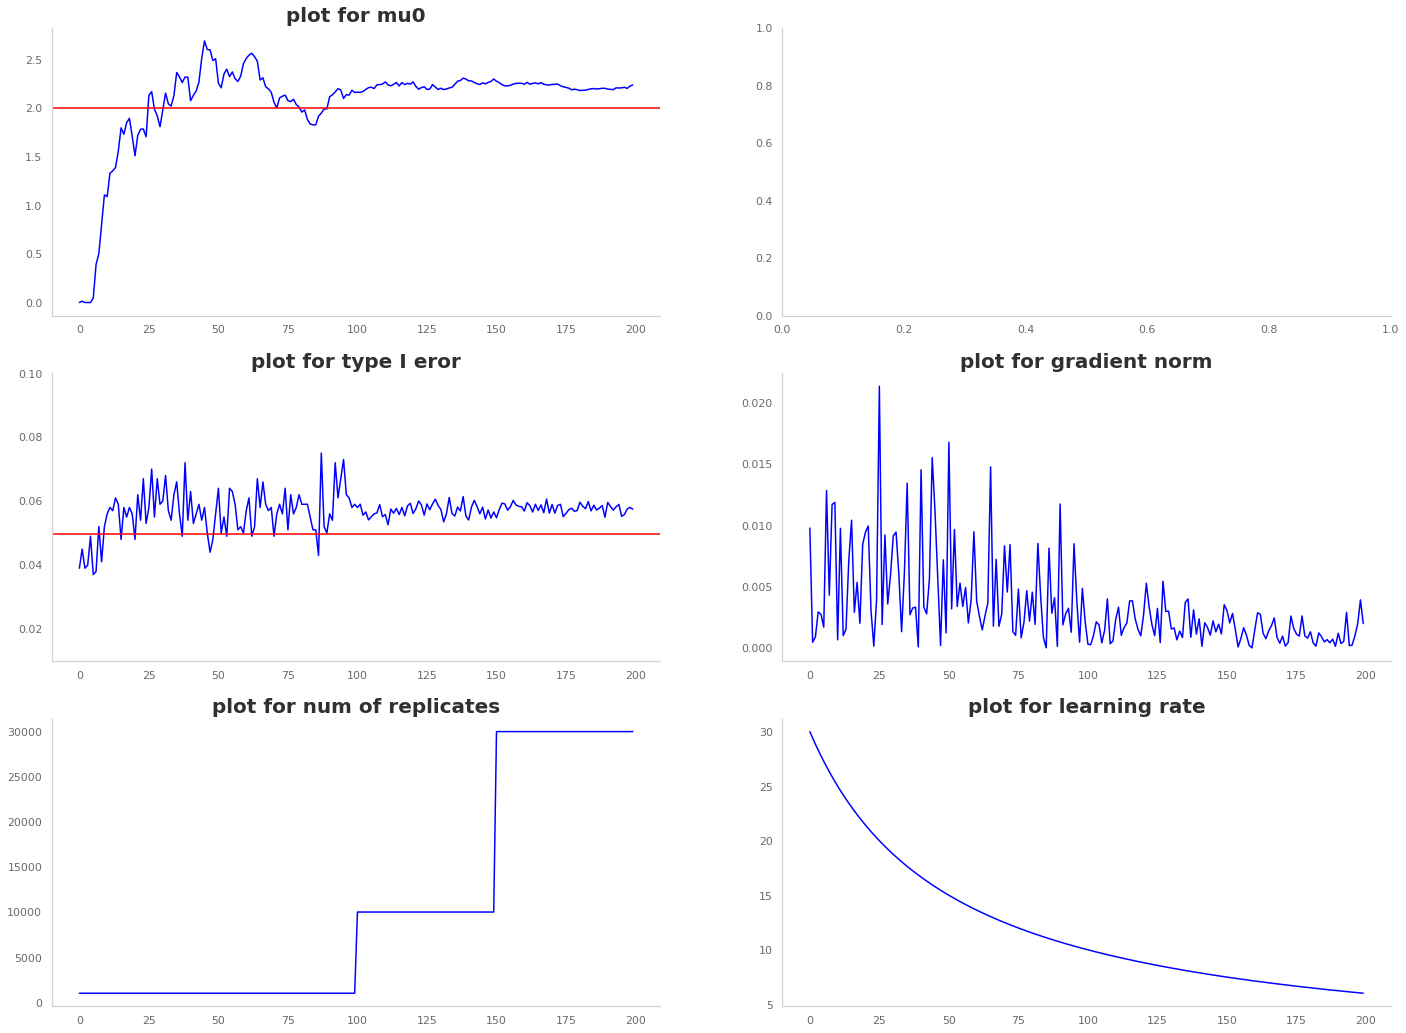

CPU times: user 9.78 s, sys: 31.1 s, total: 40.9 s
Wall time: 1min 50s


In [14]:
%%time
seed(2022)

m = 3
r = 2
k = r - 1

f = f_bonferroni
N = 500

    
def get_pvals_core(Z_hold, mu):
    XX = Z_hold + mu
    return cpch(XX, m, r, f, pdf=norm.pdf, cdf=norm.cdf, N=N)
def get_grad_core(Z_hold, pvals_hold):
    return  -(Z_hold)[:,:(r-1)]*(pvals_hold <= alpha)[:, np.newaxis]

mu_cur = gen_init(m=m, r=r)
print(f'init at mu={mu_cur}')
mu_seq = []
err_seq = []
gradnorm_seq = [] 
Tmax = 200
lrate0 = 30
lrate_seq = [max(lrate0/(1 + 0.02*tt), 2) for tt in range(Tmax)]
K_seq = []
# lrate_seq = [lrate0*0.95**tt for tt in range()]
for tt in range(Tmax):
    ## exponential decay
    lrate = lrate_seq[tt]
    if tt % 10 == 0:
        print(f'epoch: {tt}, learn rate: {lrate}')
    if tt < 100:
        K = 1e3
        # K = 96*1280
    elif tt < 150:
        K = 1e4
    else:
        K = 3e4#1e5
    K = int(K)
    K_seq.append(K)
    ## shuffle for mini batch
    # Z_mini = normal(scale=1, size=[K, n])
    # X_mini = Z_mini + mu_cur
    # pvals = get_pvals_core(Z_mini, mu_cur)
    # grads = get_grad(n, r, X_mini, mu_cur, pvals, alpha)
    
    Z_list = [normal(scale=1, size=[K//cpus, m]) for _ in range(cpus)]
    Z_all = np.vstack(Z_list)
    star_args = [[Z_list[o], mu_cur] for o in range(cpus)]
    with Pool(processes=cpus) as pool:
        pvals= np.hstack(pool.starmap(get_pvals_core, star_args))
    grads = get_grad_core(Z_all, pvals)
    
    diff = lrate*grads.mean(axis=0)
    mu_cur[:(r-1)] = proj(mu_cur[:(r-1)] - diff)
    mu_seq.append(mu_cur[:(r-1)].copy())
    err_seq.append((pvals <= alpha).mean())
    gradnorm_seq.append(npnorm(grads.mean(axis=0), np.inf))
mu_seq = np.vstack(mu_seq)
print('final epoch error:', err_seq[-1])

print('se cal:', np.sqrt(1/20/K))
print('max type I error:', err_seq[-1], 'at mu =', mu_seq[-1,:])

fig, axs = plt.subplots(3, max(mu_seq.shape[1], 2), figsize = (24, 18))
for i in range(mu_seq.shape[1]):
    _ = axs[0,i].plot(range(mu_seq.shape[0]), mu_seq[:,i], color = 'blue')
    axs[0,i].axhline(y=2, c="red")
    axs[0,i].set_title(f'plot for mu{i}', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,0].plot(range(len(err_seq)), err_seq, color = 'blue')
axs[1,0].axhline(y=0.0496, c="red")
axs[1,0].set_ylim([0.01, 0.1])
axs[1,0].set_title(f'plot for type I eror', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,1].plot(range(len(gradnorm_seq)), gradnorm_seq, color = 'blue')
axs[1,1].set_title(f'plot for gradient norm', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,0].plot(range(len(K_seq)), K_seq, color = 'blue')
axs[2,0].set_title(f'plot for num of replicates', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,1].plot(range(len(lrate_seq)), lrate_seq, color = 'blue')
axs[2,1].set_title(f'plot for learning rate', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
plt.show()

# m=r=3

init at mu=[0.04679307 0.02335245 0.        ]
epoch: 0, learn rate: 30.0
epoch: 10, learn rate: 25.0
epoch: 20, learn rate: 21.42857142857143
epoch: 30, learn rate: 18.75
epoch: 40, learn rate: 16.666666666666668
epoch: 50, learn rate: 15.0
epoch: 60, learn rate: 13.636363636363635
epoch: 70, learn rate: 12.499999999999998
epoch: 80, learn rate: 11.538461538461538
epoch: 90, learn rate: 10.714285714285715
epoch: 100, learn rate: 10.0
epoch: 110, learn rate: 9.375
epoch: 120, learn rate: 8.823529411764707
epoch: 130, learn rate: 8.333333333333334
epoch: 140, learn rate: 7.894736842105263
epoch: 150, learn rate: 7.5
epoch: 160, learn rate: 7.142857142857142
epoch: 170, learn rate: 6.8181818181818175
epoch: 180, learn rate: 6.521739130434783
epoch: 190, learn rate: 6.249999999999999
final epoch error: 0.05996666666666667
se cal: 0.0012909944487358056
max type I error: 0.05996666666666667 at mu = [2.32516812 2.30054143]


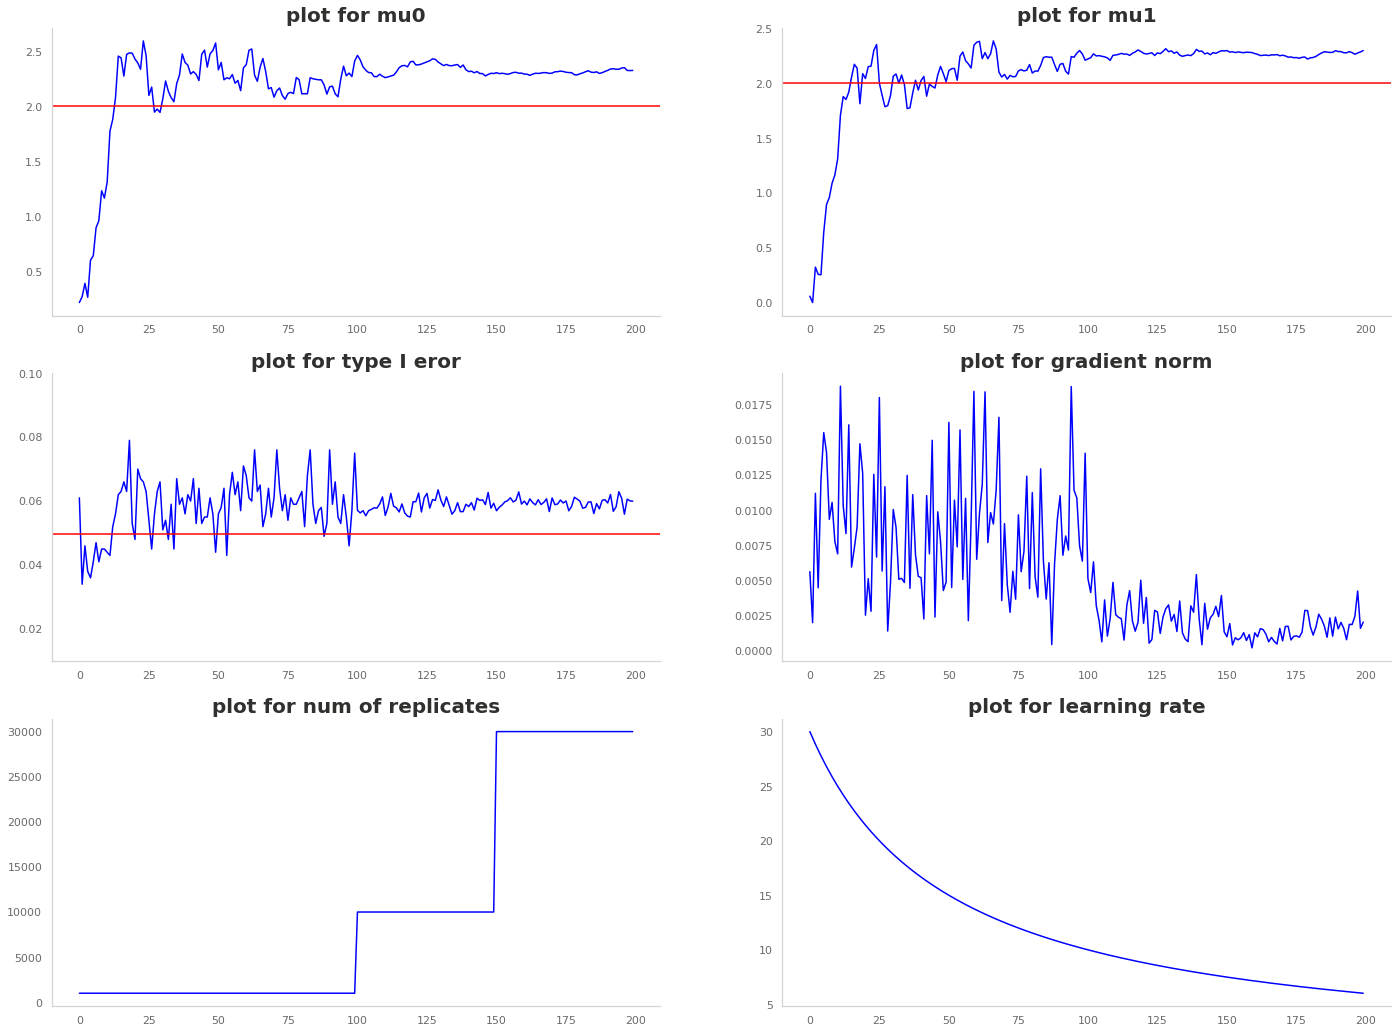

CPU times: user 10.3 s, sys: 34.3 s, total: 44.7 s
Wall time: 2min 2s


In [15]:
%%time
seed(2022)

m = 3
r = 3
k = r - 1

f = f_bonferroni
N = 500

    
def get_pvals_core(Z_hold, mu):
    XX = Z_hold + mu
    return cpch(XX, m, r, f, pdf=norm.pdf, cdf=norm.cdf, N=N)
def get_grad_core(Z_hold, pvals_hold):
    return  -(Z_hold)[:,:(r-1)]*(pvals_hold <= alpha)[:, np.newaxis]

mu_cur = gen_init(m=m, r=r)
print(f'init at mu={mu_cur}')
mu_seq = []
err_seq = []
gradnorm_seq = [] 
Tmax = 200
lrate0 = 30
lrate_seq = [max(lrate0/(1 + 0.02*tt), 2) for tt in range(Tmax)]
K_seq = []
# lrate_seq = [lrate0*0.95**tt for tt in range()]
for tt in range(Tmax):
    ## exponential decay
    lrate = lrate_seq[tt]
    if tt % 10 == 0:
        print(f'epoch: {tt}, learn rate: {lrate}')
    if tt < 100:
        K = 1e3
        # K = 96*1280
    elif tt < 150:
        K = 1e4
    else:
        K = 3e4#1e5
    K = int(K)
    K_seq.append(K)
    ## shuffle for mini batch
    # Z_mini = normal(scale=1, size=[K, n])
    # X_mini = Z_mini + mu_cur
    # pvals = get_pvals_core(Z_mini, mu_cur)
    # grads = get_grad(n, r, X_mini, mu_cur, pvals, alpha)
    
    Z_list = [normal(scale=1, size=[K//cpus, m]) for _ in range(cpus)]
    Z_all = np.vstack(Z_list)
    star_args = [[Z_list[o], mu_cur] for o in range(cpus)]
    with Pool(processes=cpus) as pool:
        pvals= np.hstack(pool.starmap(get_pvals_core, star_args))
    grads = get_grad_core(Z_all, pvals)
    
    diff = lrate*grads.mean(axis=0)
    mu_cur[:(r-1)] = proj(mu_cur[:(r-1)] - diff)
    mu_seq.append(mu_cur[:(r-1)].copy())
    err_seq.append((pvals <= alpha).mean())
    gradnorm_seq.append(npnorm(grads.mean(axis=0), np.inf))
mu_seq = np.vstack(mu_seq)
print('final epoch error:', err_seq[-1])

print('se cal:', np.sqrt(1/20/K))
print('max type I error:', err_seq[-1], 'at mu =', mu_seq[-1,:])

fig, axs = plt.subplots(3, max(mu_seq.shape[1], 2), figsize = (24, 18))
for i in range(mu_seq.shape[1]):
    _ = axs[0,i].plot(range(mu_seq.shape[0]), mu_seq[:,i], color = 'blue')
    axs[0,i].axhline(y=2, c="red")
    axs[0,i].set_title(f'plot for mu{i}', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,0].plot(range(len(err_seq)), err_seq, color = 'blue')
axs[1,0].axhline(y=0.0496, c="red")
axs[1,0].set_ylim([0.01, 0.1])
axs[1,0].set_title(f'plot for type I eror', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[1,1].plot(range(len(gradnorm_seq)), gradnorm_seq, color = 'blue')
axs[1,1].set_title(f'plot for gradient norm', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,0].plot(range(len(K_seq)), K_seq, color = 'blue')
axs[2,0].set_title(f'plot for num of replicates', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
_ = axs[2,1].plot(range(len(lrate_seq)), lrate_seq, color = 'blue')
axs[2,1].set_title(f'plot for learning rate', fontsize=20, fontweight='bold',
                 color='#30302f', loc='center')
plt.show()